In [1]:
import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHash

name = 'FNN-Classification-Simple'

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 10,
}

HASH = getHash(name,[architecture,props])
print(HASH)

FNN-Classification-Simple-sigmoid_100000_2048_1024_512_256_128_0001_CCE_10_1_1_0_1_0_e_e_0_1_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_0_05_06


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1919620, 828)
(1919620, 8)
validation
(288502, 828)
(288502, 8)
test
(221128, 828)
(221128, 8)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/'+props['space']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 2048)              1697792   


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 8)                 1032      


Total params: 4486024 (17.11 MB)


Trainable params: 4486024 (17.11 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

Epoch 1/10000


 1/20 [>.............................] - ETA: 3:39 - loss: 2.3309 - STD: 0.0879 - MAE: 0.2188

 2/20 [==>...........................] - ETA: 7s - loss: 2.2333 - STD: 0.0643 - MAE: 0.2187  

 3/20 [===>..........................] - ETA: 7s - loss: 2.1870 - STD: 0.0514 - MAE: 0.2186

 4/20 [=====>........................] - ETA: 7s - loss: 2.1663 - STD: 0.0449 - MAE: 0.2186

 5/20 [======>.......................] - ETA: 6s - loss: 2.1564 - STD: 0.0422 - MAE: 0.2187

 6/20 [========>.....................] - ETA: 6s - loss: 2.1510 - STD: 0.0410 - MAE: 0.2187

 7/20 [=========>....................] - ETA: 5s - loss: 2.1467 - STD: 0.0401 - MAE: 0.2187

 8/20 [===========>..................] - ETA: 5s - loss: 2.1419 - STD: 0.0388 - MAE: 0.2187

 9/20 [============>.................] - ETA: 4s - loss: 2.1366 - STD: 0.0370 - MAE: 0.2187

10/20 [==============>...............] - ETA: 4s - loss: 2.1314 - STD: 0.0347 - MAE: 0.2187

11/20 [===============>..............] - ETA: 3s - loss: 2.1268 - STD: 0.0325 - MAE: 0.2187

12/20 [=================>............] - ETA: 3s - loss: 2.1231 - STD: 0.0308 - MAE: 0.2187

13/20 [==================>...........] - ETA: 2s - loss: 2.1201 - STD: 0.0296 - MAE: 0.2187

14/20 [====================>.........] - ETA: 3s - loss: 2.1196 - STD: 0.0288 - MAE: 0.2187

15/20 [=====================>........] - ETA: 3s - loss: 2.1175 - STD: 0.0282 - MAE: 0.2187

16/20 [=======================>......] - ETA: 2s - loss: 2.1156 - STD: 0.0277 - MAE: 0.2187

17/20 [========================>.....] - ETA: 1s - loss: 2.1139 - STD: 0.0273 - MAE: 0.2187

18/20 [==========================>...] - ETA: 1s - loss: 2.1123 - STD: 0.0268 - MAE: 0.2187

19/20 [===========================>..] - ETA: 0s - loss: 2.1108 - STD: 0.0263 - MAE: 0.2187

20/20 [==============================] - ETA: 0s - loss: 2.1093 - STD: 0.0258 - MAE: 0.2187

20/20 [==============================] - 28s 841ms/step - loss: 2.1093 - STD: 0.0258 - MAE: 0.2187 - val_loss: 2.0780 - val_STD: 0.0127 - val_MAE: 0.2185


Epoch 2/10000


 1/20 [>.............................] - ETA: 14s - loss: 2.0801 - STD: 0.0127 - MAE: 0.2186

 2/20 [==>...........................] - ETA: 9s - loss: 2.0795 - STD: 0.0116 - MAE: 0.2186 

 3/20 [===>..........................] - ETA: 7s - loss: 2.0793 - STD: 0.0108 - MAE: 0.2186

 4/20 [=====>........................] - ETA: 7s - loss: 2.0793 - STD: 0.0104 - MAE: 0.2186

 5/20 [======>.......................] - ETA: 6s - loss: 2.0795 - STD: 0.0102 - MAE: 0.2186

 6/20 [========>.....................] - ETA: 5s - loss: 2.0796 - STD: 0.0102 - MAE: 0.2187

 7/20 [=========>....................] - ETA: 4s - loss: 2.0800 - STD: 0.0102 - MAE: 0.2187

 8/20 [===========>..................] - ETA: 4s - loss: 2.0802 - STD: 0.0101 - MAE: 0.2187

 9/20 [============>.................] - ETA: 4s - loss: 2.0803 - STD: 0.0100 - MAE: 0.2187

10/20 [==============>...............] - ETA: 4s - loss: 2.0803 - STD: 0.0097 - MAE: 0.2187

11/20 [===============>..............] - ETA: 3s - loss: 2.0802 - STD: 0.0094 - MAE: 0.2187

12/20 [=================>............] - ETA: 3s - loss: 2.0800 - STD: 0.0091 - MAE: 0.2187

13/20 [==================>...........] - ETA: 2s - loss: 2.0799 - STD: 0.0089 - MAE: 0.2187

14/20 [====================>.........] - ETA: 2s - loss: 2.0797 - STD: 0.0088 - MAE: 0.2187

15/20 [=====================>........] - ETA: 2s - loss: 2.0797 - STD: 0.0088 - MAE: 0.2187

16/20 [=======================>......] - ETA: 1s - loss: 2.0796 - STD: 0.0088 - MAE: 0.2187

17/20 [========================>.....] - ETA: 1s - loss: 2.0795 - STD: 0.0089 - MAE: 0.2187

18/20 [==========================>...] - ETA: 0s - loss: 2.0795 - STD: 0.0090 - MAE: 0.2187

19/20 [===========================>..] - ETA: 0s - loss: 2.0795 - STD: 0.0091 - MAE: 0.2187

20/20 [==============================] - ETA: 0s - loss: 2.0794 - STD: 0.0092 - MAE: 0.2187

20/20 [==============================] - 10s 484ms/step - loss: 2.0794 - STD: 0.0092 - MAE: 0.2187 - val_loss: 2.0767 - val_STD: 0.0096 - val_MAE: 0.2186


Epoch 3/10000


 1/20 [>.............................] - ETA: 14s - loss: 2.0786 - STD: 0.0096 - MAE: 0.2186

 2/20 [==>...........................] - ETA: 7s - loss: 2.0783 - STD: 0.0091 - MAE: 0.2186 

 3/20 [===>..........................] - ETA: 6s - loss: 2.0781 - STD: 0.0086 - MAE: 0.2186

 4/20 [=====>........................] - ETA: 7s - loss: 2.0781 - STD: 0.0082 - MAE: 0.2186

 5/20 [======>.......................] - ETA: 6s - loss: 2.0780 - STD: 0.0077 - MAE: 0.2186

 6/20 [========>.....................] - ETA: 5s - loss: 2.0780 - STD: 0.0074 - MAE: 0.2186

 7/20 [=========>....................] - ETA: 5s - loss: 2.0779 - STD: 0.0071 - MAE: 0.2186

 8/20 [===========>..................] - ETA: 5s - loss: 2.0779 - STD: 0.0069 - MAE: 0.2187

 9/20 [============>.................] - ETA: 4s - loss: 2.0779 - STD: 0.0068 - MAE: 0.2187

10/20 [==============>...............] - ETA: 3s - loss: 2.0779 - STD: 0.0068 - MAE: 0.2187

11/20 [===============>..............] - ETA: 3s - loss: 2.0779 - STD: 0.0067 - MAE: 0.2187

12/20 [=================>............] - ETA: 3s - loss: 2.0778 - STD: 0.0067 - MAE: 0.2187

13/20 [==================>...........] - ETA: 2s - loss: 2.0777 - STD: 0.0067 - MAE: 0.2186

14/20 [====================>.........] - ETA: 2s - loss: 2.0776 - STD: 0.0067 - MAE: 0.2186

15/20 [=====================>........] - ETA: 2s - loss: 2.0775 - STD: 0.0067 - MAE: 0.2186

16/20 [=======================>......] - ETA: 1s - loss: 2.0774 - STD: 0.0068 - MAE: 0.2186

17/20 [========================>.....] - ETA: 1s - loss: 2.0773 - STD: 0.0068 - MAE: 0.2186

18/20 [==========================>...] - ETA: 0s - loss: 2.0772 - STD: 0.0069 - MAE: 0.2186

19/20 [===========================>..] - ETA: 0s - loss: 2.0770 - STD: 0.0070 - MAE: 0.2186

20/20 [==============================] - ETA: 0s - loss: 2.0768 - STD: 0.0070 - MAE: 0.2186

20/20 [==============================] - 10s 496ms/step - loss: 2.0768 - STD: 0.0070 - MAE: 0.2186 - val_loss: 2.0718 - val_STD: 0.0076 - val_MAE: 0.2184


Epoch 4/10000


 1/20 [>.............................] - ETA: 16s - loss: 2.0728 - STD: 0.0075 - MAE: 0.2185

 2/20 [==>...........................] - ETA: 8s - loss: 2.0719 - STD: 0.0074 - MAE: 0.2185 

 3/20 [===>..........................] - ETA: 7s - loss: 2.0711 - STD: 0.0074 - MAE: 0.2184

 4/20 [=====>........................] - ETA: 6s - loss: 2.0703 - STD: 0.0075 - MAE: 0.2184

 5/20 [======>.......................] - ETA: 6s - loss: 2.0693 - STD: 0.0075 - MAE: 0.2184

 6/20 [========>.....................] - ETA: 5s - loss: 2.0682 - STD: 0.0075 - MAE: 0.2183

 7/20 [=========>....................] - ETA: 5s - loss: 2.0670 - STD: 0.0076 - MAE: 0.2183

 8/20 [===========>..................] - ETA: 4s - loss: 2.0655 - STD: 0.0077 - MAE: 0.2182

 9/20 [============>.................] - ETA: 4s - loss: 2.0638 - STD: 0.0079 - MAE: 0.2182

10/20 [==============>...............] - ETA: 4s - loss: 2.0619 - STD: 0.0081 - MAE: 0.2181

11/20 [===============>..............] - ETA: 3s - loss: 2.0596 - STD: 0.0085 - MAE: 0.2180

12/20 [=================>............] - ETA: 3s - loss: 2.0571 - STD: 0.0090 - MAE: 0.2179

13/20 [==================>...........] - ETA: 2s - loss: 2.0542 - STD: 0.0096 - MAE: 0.2178

14/20 [====================>.........] - ETA: 2s - loss: 2.0509 - STD: 0.0104 - MAE: 0.2177

15/20 [=====================>........] - ETA: 2s - loss: 2.0472 - STD: 0.0113 - MAE: 0.2176

16/20 [=======================>......] - ETA: 1s - loss: 2.0432 - STD: 0.0123 - MAE: 0.2174

17/20 [========================>.....] - ETA: 1s - loss: 2.0388 - STD: 0.0135 - MAE: 0.2172

18/20 [==========================>...] - ETA: 0s - loss: 2.0342 - STD: 0.0148 - MAE: 0.2170

19/20 [===========================>..] - ETA: 0s - loss: 2.0293 - STD: 0.0162 - MAE: 0.2168

20/20 [==============================] - ETA: 0s - loss: 2.0283 - STD: 0.0177 - MAE: 0.2165

20/20 [==============================] - 10s 464ms/step - loss: 2.0283 - STD: 0.0177 - MAE: 0.2165 - val_loss: 1.9268 - val_STD: 0.0504 - val_MAE: 0.2114


Epoch 5/10000


 1/20 [>.............................] - ETA: 17s - loss: 1.9145 - STD: 0.0516 - MAE: 0.2110

 2/20 [==>...........................] - ETA: 7s - loss: 1.9103 - STD: 0.0535 - MAE: 0.2107 

 3/20 [===>..........................] - ETA: 6s - loss: 1.9053 - STD: 0.0553 - MAE: 0.2103

 4/20 [=====>........................] - ETA: 6s - loss: 1.9002 - STD: 0.0566 - MAE: 0.2100

 5/20 [======>.......................] - ETA: 6s - loss: 1.8953 - STD: 0.0578 - MAE: 0.2097

 6/20 [========>.....................] - ETA: 5s - loss: 1.8905 - STD: 0.0588 - MAE: 0.2094

 7/20 [=========>....................] - ETA: 5s - loss: 1.8859 - STD: 0.0599 - MAE: 0.2092

 8/20 [===========>..................] - ETA: 4s - loss: 1.8819 - STD: 0.0611 - MAE: 0.2089

 9/20 [============>.................] - ETA: 4s - loss: 1.8790 - STD: 0.0626 - MAE: 0.2086

10/20 [==============>...............] - ETA: 3s - loss: 1.8785 - STD: 0.0639 - MAE: 0.2083

11/20 [===============>..............] - ETA: 3s - loss: 1.8737 - STD: 0.0652 - MAE: 0.2080

12/20 [=================>............] - ETA: 3s - loss: 1.8698 - STD: 0.0664 - MAE: 0.2078

13/20 [==================>...........] - ETA: 2s - loss: 1.8667 - STD: 0.0672 - MAE: 0.2076

14/20 [====================>.........] - ETA: 2s - loss: 1.8624 - STD: 0.0681 - MAE: 0.2073

15/20 [=====================>........] - ETA: 1s - loss: 1.8591 - STD: 0.0691 - MAE: 0.2071

16/20 [=======================>......] - ETA: 1s - loss: 1.8557 - STD: 0.0699 - MAE: 0.2069

17/20 [========================>.....] - ETA: 1s - loss: 1.8520 - STD: 0.0707 - MAE: 0.2066

18/20 [==========================>...] - ETA: 0s - loss: 1.8491 - STD: 0.0716 - MAE: 0.2064

19/20 [===========================>..] - ETA: 0s - loss: 1.8455 - STD: 0.0723 - MAE: 0.2062

20/20 [==============================] - ETA: 0s - loss: 1.8419 - STD: 0.0730 - MAE: 0.2060

20/20 [==============================] - 10s 475ms/step - loss: 1.8419 - STD: 0.0730 - MAE: 0.2060 - val_loss: 1.7787 - val_STD: 0.0823 - val_MAE: 0.2026


Epoch 6/10000


 1/20 [>.............................] - ETA: 13s - loss: 1.7691 - STD: 0.0873 - MAE: 0.2017

 2/20 [==>...........................] - ETA: 7s - loss: 1.7611 - STD: 0.0881 - MAE: 0.2013 

 3/20 [===>..........................] - ETA: 7s - loss: 1.7581 - STD: 0.0893 - MAE: 0.2009

 4/20 [=====>........................] - ETA: 5s - loss: 1.7570 - STD: 0.0901 - MAE: 0.2006

 5/20 [======>.......................] - ETA: 5s - loss: 1.7502 - STD: 0.0905 - MAE: 0.2004

 6/20 [========>.....................] - ETA: 4s - loss: 1.7455 - STD: 0.0909 - MAE: 0.2002

 7/20 [=========>....................] - ETA: 4s - loss: 1.7421 - STD: 0.0912 - MAE: 0.2001

 8/20 [===========>..................] - ETA: 4s - loss: 1.7391 - STD: 0.0918 - MAE: 0.1999

 9/20 [============>.................] - ETA: 4s - loss: 1.7343 - STD: 0.0924 - MAE: 0.1996

10/20 [==============>...............] - ETA: 3s - loss: 1.7302 - STD: 0.0931 - MAE: 0.1993

11/20 [===============>..............] - ETA: 3s - loss: 1.7263 - STD: 0.0937 - MAE: 0.1991

12/20 [=================>............] - ETA: 3s - loss: 1.7233 - STD: 0.0941 - MAE: 0.1989

13/20 [==================>...........] - ETA: 2s - loss: 1.7211 - STD: 0.0947 - MAE: 0.1987

14/20 [====================>.........] - ETA: 2s - loss: 1.7192 - STD: 0.0951 - MAE: 0.1986

15/20 [=====================>........] - ETA: 1s - loss: 1.7172 - STD: 0.0958 - MAE: 0.1984

16/20 [=======================>......] - ETA: 1s - loss: 1.7144 - STD: 0.0962 - MAE: 0.1982

17/20 [========================>.....] - ETA: 1s - loss: 1.7114 - STD: 0.0967 - MAE: 0.1980

18/20 [==========================>...] - ETA: 0s - loss: 1.7093 - STD: 0.0974 - MAE: 0.1978

19/20 [===========================>..] - ETA: 0s - loss: 1.7068 - STD: 0.0978 - MAE: 0.1976

20/20 [==============================] - ETA: 0s - loss: 1.7042 - STD: 0.0982 - MAE: 0.1974

20/20 [==============================] - 9s 442ms/step - loss: 1.7042 - STD: 0.0982 - MAE: 0.1974 - val_loss: 1.6840 - val_STD: 0.1008 - val_MAE: 0.1964


Epoch 7/10000


 1/20 [>.............................] - ETA: 12s - loss: 1.6551 - STD: 0.1093 - MAE: 0.1934

 2/20 [==>...........................] - ETA: 7s - loss: 1.6569 - STD: 0.1088 - MAE: 0.1936 

 3/20 [===>..........................] - ETA: 6s - loss: 1.6551 - STD: 0.1093 - MAE: 0.1934

 4/20 [=====>........................] - ETA: 6s - loss: 1.6526 - STD: 0.1095 - MAE: 0.1933

 5/20 [======>.......................] - ETA: 6s - loss: 1.6508 - STD: 0.1093 - MAE: 0.1933

 6/20 [========>.....................] - ETA: 5s - loss: 1.6495 - STD: 0.1095 - MAE: 0.1932

 7/20 [=========>....................] - ETA: 5s - loss: 1.6472 - STD: 0.1098 - MAE: 0.1930

 8/20 [===========>..................] - ETA: 4s - loss: 1.6453 - STD: 0.1101 - MAE: 0.1929

 9/20 [============>.................] - ETA: 4s - loss: 1.6438 - STD: 0.1103 - MAE: 0.1928

10/20 [==============>...............] - ETA: 4s - loss: 1.6425 - STD: 0.1104 - MAE: 0.1927

11/20 [===============>..............] - ETA: 3s - loss: 1.6410 - STD: 0.1105 - MAE: 0.1926

12/20 [=================>............] - ETA: 3s - loss: 1.6397 - STD: 0.1106 - MAE: 0.1925

13/20 [==================>...........] - ETA: 2s - loss: 1.6382 - STD: 0.1108 - MAE: 0.1924

14/20 [====================>.........] - ETA: 2s - loss: 1.6365 - STD: 0.1110 - MAE: 0.1923

15/20 [=====================>........] - ETA: 2s - loss: 1.6346 - STD: 0.1111 - MAE: 0.1922

16/20 [=======================>......] - ETA: 1s - loss: 1.6341 - STD: 0.1112 - MAE: 0.1921

17/20 [========================>.....] - ETA: 1s - loss: 1.6320 - STD: 0.1114 - MAE: 0.1920

18/20 [==========================>...] - ETA: 0s - loss: 1.6301 - STD: 0.1116 - MAE: 0.1919

19/20 [===========================>..] - ETA: 0s - loss: 1.6287 - STD: 0.1119 - MAE: 0.1918

20/20 [==============================] - ETA: 0s - loss: 1.6283 - STD: 0.1120 - MAE: 0.1917

20/20 [==============================] - 10s 467ms/step - loss: 1.6283 - STD: 0.1120 - MAE: 0.1917 - val_loss: 1.6435 - val_STD: 0.1117 - val_MAE: 0.1922


Epoch 8/10000


 1/20 [>.............................] - ETA: 15s - loss: 1.6197 - STD: 0.1170 - MAE: 0.1902

 2/20 [==>...........................] - ETA: 7s - loss: 1.6049 - STD: 0.1159 - MAE: 0.1898 

 3/20 [===>..........................] - ETA: 7s - loss: 1.5942 - STD: 0.1159 - MAE: 0.1894

 4/20 [=====>........................] - ETA: 6s - loss: 1.5928 - STD: 0.1164 - MAE: 0.1893

 5/20 [======>.......................] - ETA: 6s - loss: 1.5892 - STD: 0.1165 - MAE: 0.1891

 6/20 [========>.....................] - ETA: 5s - loss: 1.5823 - STD: 0.1163 - MAE: 0.1888

 7/20 [=========>....................] - ETA: 5s - loss: 1.5784 - STD: 0.1164 - MAE: 0.1886

 8/20 [===========>..................] - ETA: 4s - loss: 1.5746 - STD: 0.1167 - MAE: 0.1884

 9/20 [============>.................] - ETA: 4s - loss: 1.5680 - STD: 0.1170 - MAE: 0.1880

10/20 [==============>...............] - ETA: 4s - loss: 1.5637 - STD: 0.1173 - MAE: 0.1878

11/20 [===============>..............] - ETA: 3s - loss: 1.5594 - STD: 0.1175 - MAE: 0.1875

12/20 [=================>............] - ETA: 3s - loss: 1.5531 - STD: 0.1179 - MAE: 0.1871

13/20 [==================>...........] - ETA: 2s - loss: 1.5479 - STD: 0.1184 - MAE: 0.1868

14/20 [====================>.........] - ETA: 2s - loss: 1.5433 - STD: 0.1189 - MAE: 0.1865

15/20 [=====================>........] - ETA: 2s - loss: 1.5369 - STD: 0.1195 - MAE: 0.1861

16/20 [=======================>......] - ETA: 1s - loss: 1.5313 - STD: 0.1203 - MAE: 0.1857

17/20 [========================>.....] - ETA: 1s - loss: 1.5266 - STD: 0.1210 - MAE: 0.1853

18/20 [==========================>...] - ETA: 0s - loss: 1.5211 - STD: 0.1218 - MAE: 0.1849

19/20 [===========================>..] - ETA: 0s - loss: 1.5200 - STD: 0.1226 - MAE: 0.1844

20/20 [==============================] - ETA: 0s - loss: 1.5153 - STD: 0.1235 - MAE: 0.1841

20/20 [==============================] - 10s 459ms/step - loss: 1.5153 - STD: 0.1235 - MAE: 0.1841 - val_loss: 1.3928 - val_STD: 0.1390 - val_MAE: 0.1755


Epoch 9/10000


 1/20 [>.............................] - ETA: 13s - loss: 1.4159 - STD: 0.1419 - MAE: 0.1754

 2/20 [==>...........................] - ETA: 7s - loss: 1.4092 - STD: 0.1426 - MAE: 0.1750 

 3/20 [===>..........................] - ETA: 6s - loss: 1.4074 - STD: 0.1438 - MAE: 0.1746

 4/20 [=====>........................] - ETA: 6s - loss: 1.4071 - STD: 0.1449 - MAE: 0.1743

 5/20 [======>.......................] - ETA: 6s - loss: 1.4061 - STD: 0.1456 - MAE: 0.1741

 6/20 [========>.....................] - ETA: 5s - loss: 1.4040 - STD: 0.1463 - MAE: 0.1738

 7/20 [=========>....................] - ETA: 5s - loss: 1.4029 - STD: 0.1468 - MAE: 0.1736

 8/20 [===========>..................] - ETA: 4s - loss: 1.4020 - STD: 0.1472 - MAE: 0.1735

 9/20 [============>.................] - ETA: 4s - loss: 1.4006 - STD: 0.1477 - MAE: 0.1733

10/20 [==============>...............] - ETA: 4s - loss: 1.3989 - STD: 0.1481 - MAE: 0.1731

11/20 [===============>..............] - ETA: 3s - loss: 1.3980 - STD: 0.1484 - MAE: 0.1729

12/20 [=================>............] - ETA: 3s - loss: 1.3965 - STD: 0.1488 - MAE: 0.1728

13/20 [==================>...........] - ETA: 2s - loss: 1.3952 - STD: 0.1491 - MAE: 0.1726

14/20 [====================>.........] - ETA: 2s - loss: 1.3942 - STD: 0.1493 - MAE: 0.1725

15/20 [=====================>........] - ETA: 2s - loss: 1.3941 - STD: 0.1495 - MAE: 0.1725

16/20 [=======================>......] - ETA: 1s - loss: 1.3927 - STD: 0.1496 - MAE: 0.1724

17/20 [========================>.....] - ETA: 1s - loss: 1.3917 - STD: 0.1496 - MAE: 0.1723

18/20 [==========================>...] - ETA: 0s - loss: 1.3906 - STD: 0.1497 - MAE: 0.1723

19/20 [===========================>..] - ETA: 0s - loss: 1.3898 - STD: 0.1498 - MAE: 0.1722

20/20 [==============================] - ETA: 0s - loss: 1.3887 - STD: 0.1499 - MAE: 0.1721

20/20 [==============================] - 9s 459ms/step - loss: 1.3887 - STD: 0.1499 - MAE: 0.1721 - val_loss: 1.3478 - val_STD: 0.1488 - val_MAE: 0.1707


Epoch 10/10000


 1/20 [>.............................] - ETA: 12s - loss: 1.3654 - STD: 0.1517 - MAE: 0.1705

 2/20 [==>...........................] - ETA: 7s - loss: 1.3652 - STD: 0.1515 - MAE: 0.1705 

 3/20 [===>..........................] - ETA: 6s - loss: 1.3660 - STD: 0.1512 - MAE: 0.1706

 4/20 [=====>........................] - ETA: 6s - loss: 1.3653 - STD: 0.1517 - MAE: 0.1705

 5/20 [======>.......................] - ETA: 6s - loss: 1.3645 - STD: 0.1518 - MAE: 0.1704

 6/20 [========>.....................] - ETA: 6s - loss: 1.3620 - STD: 0.1522 - MAE: 0.1702

 7/20 [=========>....................] - ETA: 5s - loss: 1.3610 - STD: 0.1525 - MAE: 0.1700

 8/20 [===========>..................] - ETA: 5s - loss: 1.3605 - STD: 0.1526 - MAE: 0.1700

 9/20 [============>.................] - ETA: 4s - loss: 1.3601 - STD: 0.1528 - MAE: 0.1699

10/20 [==============>...............] - ETA: 4s - loss: 1.3591 - STD: 0.1528 - MAE: 0.1699

11/20 [===============>..............] - ETA: 3s - loss: 1.3590 - STD: 0.1529 - MAE: 0.1698

12/20 [=================>............] - ETA: 3s - loss: 1.3587 - STD: 0.1531 - MAE: 0.1697

13/20 [==================>...........] - ETA: 2s - loss: 1.3577 - STD: 0.1533 - MAE: 0.1696

14/20 [====================>.........] - ETA: 2s - loss: 1.3567 - STD: 0.1535 - MAE: 0.1695

15/20 [=====================>........] - ETA: 2s - loss: 1.3557 - STD: 0.1536 - MAE: 0.1694

16/20 [=======================>......] - ETA: 1s - loss: 1.3548 - STD: 0.1536 - MAE: 0.1694

17/20 [========================>.....] - ETA: 1s - loss: 1.3538 - STD: 0.1537 - MAE: 0.1693

18/20 [==========================>...] - ETA: 0s - loss: 1.3529 - STD: 0.1538 - MAE: 0.1692

19/20 [===========================>..] - ETA: 0s - loss: 1.3523 - STD: 0.1539 - MAE: 0.1691

20/20 [==============================] - ETA: 0s - loss: 1.3526 - STD: 0.1542 - MAE: 0.1691

20/20 [==============================] - 10s 473ms/step - loss: 1.3526 - STD: 0.1542 - MAE: 0.1691 - val_loss: 1.3614 - val_STD: 0.1549 - val_MAE: 0.1694


Epoch 11/10000


 1/20 [>.............................] - ETA: 12s - loss: 1.3607 - STD: 0.1566 - MAE: 0.1687

 2/20 [==>...........................] - ETA: 7s - loss: 1.3632 - STD: 0.1573 - MAE: 0.1684 

 3/20 [===>..........................] - ETA: 6s - loss: 1.3592 - STD: 0.1571 - MAE: 0.1683

 4/20 [=====>........................] - ETA: 6s - loss: 1.3541 - STD: 0.1568 - MAE: 0.1681

 5/20 [======>.......................] - ETA: 4s - loss: 1.3527 - STD: 0.1572 - MAE: 0.1678

 6/20 [========>.....................] - ETA: 4s - loss: 1.3516 - STD: 0.1574 - MAE: 0.1677

 7/20 [=========>....................] - ETA: 4s - loss: 1.3515 - STD: 0.1576 - MAE: 0.1676

 8/20 [===========>..................] - ETA: 4s - loss: 1.3485 - STD: 0.1576 - MAE: 0.1675

 9/20 [============>.................] - ETA: 4s - loss: 1.3460 - STD: 0.1575 - MAE: 0.1675

10/20 [==============>...............] - ETA: 3s - loss: 1.3455 - STD: 0.1574 - MAE: 0.1675

11/20 [===============>..............] - ETA: 3s - loss: 1.3441 - STD: 0.1575 - MAE: 0.1674

12/20 [=================>............] - ETA: 3s - loss: 1.3418 - STD: 0.1576 - MAE: 0.1673

13/20 [==================>...........] - ETA: 2s - loss: 1.3402 - STD: 0.1577 - MAE: 0.1671

14/20 [====================>.........] - ETA: 2s - loss: 1.3385 - STD: 0.1578 - MAE: 0.1670

15/20 [=====================>........] - ETA: 1s - loss: 1.3372 - STD: 0.1579 - MAE: 0.1669

16/20 [=======================>......] - ETA: 1s - loss: 1.3362 - STD: 0.1579 - MAE: 0.1669

17/20 [========================>.....] - ETA: 1s - loss: 1.3352 - STD: 0.1579 - MAE: 0.1669

18/20 [==========================>...] - ETA: 0s - loss: 1.3339 - STD: 0.1580 - MAE: 0.1667

19/20 [===========================>..] - ETA: 0s - loss: 1.3330 - STD: 0.1581 - MAE: 0.1667

20/20 [==============================] - ETA: 0s - loss: 1.3323 - STD: 0.1582 - MAE: 0.1666

20/20 [==============================] - 9s 455ms/step - loss: 1.3323 - STD: 0.1582 - MAE: 0.1666 - val_loss: 1.3150 - val_STD: 0.1565 - val_MAE: 0.1664


Epoch 12/10000


 1/20 [>.............................] - ETA: 13s - loss: 1.3126 - STD: 0.1588 - MAE: 0.1653

 2/20 [==>...........................] - ETA: 6s - loss: 1.3105 - STD: 0.1591 - MAE: 0.1651 

 3/20 [===>..........................] - ETA: 6s - loss: 1.3095 - STD: 0.1592 - MAE: 0.1650

 4/20 [=====>........................] - ETA: 6s - loss: 1.3092 - STD: 0.1594 - MAE: 0.1649

 5/20 [======>.......................] - ETA: 5s - loss: 1.3080 - STD: 0.1597 - MAE: 0.1648

 6/20 [========>.....................] - ETA: 5s - loss: 1.3073 - STD: 0.1599 - MAE: 0.1647

 7/20 [=========>....................] - ETA: 5s - loss: 1.3067 - STD: 0.1599 - MAE: 0.1647

 8/20 [===========>..................] - ETA: 4s - loss: 1.3057 - STD: 0.1600 - MAE: 0.1646

 9/20 [============>.................] - ETA: 3s - loss: 1.3054 - STD: 0.1602 - MAE: 0.1645

10/20 [==============>...............] - ETA: 3s - loss: 1.3048 - STD: 0.1604 - MAE: 0.1643

11/20 [===============>..............] - ETA: 3s - loss: 1.3040 - STD: 0.1606 - MAE: 0.1642

12/20 [=================>............] - ETA: 2s - loss: 1.3030 - STD: 0.1608 - MAE: 0.1641

13/20 [==================>...........] - ETA: 2s - loss: 1.3033 - STD: 0.1608 - MAE: 0.1641

14/20 [====================>.........] - ETA: 2s - loss: 1.3044 - STD: 0.1611 - MAE: 0.1641

15/20 [=====================>........] - ETA: 1s - loss: 1.3076 - STD: 0.1611 - MAE: 0.1642

16/20 [=======================>......] - ETA: 1s - loss: 1.3105 - STD: 0.1614 - MAE: 0.1643

17/20 [========================>.....] - ETA: 1s - loss: 1.3103 - STD: 0.1615 - MAE: 0.1642

18/20 [==========================>...] - ETA: 0s - loss: 1.3094 - STD: 0.1614 - MAE: 0.1642

19/20 [===========================>..] - ETA: 0s - loss: 1.3100 - STD: 0.1616 - MAE: 0.1641

20/20 [==============================] - ETA: 0s - loss: 1.3096 - STD: 0.1617 - MAE: 0.1641

20/20 [==============================] - 9s 446ms/step - loss: 1.3096 - STD: 0.1617 - MAE: 0.1641 - val_loss: 1.3131 - val_STD: 0.1584 - val_MAE: 0.1654


Epoch 13/10000


 1/20 [>.............................] - ETA: 12s - loss: 1.3053 - STD: 0.1617 - MAE: 0.1636

 2/20 [==>...........................] - ETA: 7s - loss: 1.3059 - STD: 0.1629 - MAE: 0.1633 

 3/20 [===>..........................] - ETA: 7s - loss: 1.3004 - STD: 0.1628 - MAE: 0.1631

 4/20 [=====>........................] - ETA: 6s - loss: 1.3008 - STD: 0.1627 - MAE: 0.1631

 5/20 [======>.......................] - ETA: 6s - loss: 1.3016 - STD: 0.1633 - MAE: 0.1630

 6/20 [========>.....................] - ETA: 5s - loss: 1.2984 - STD: 0.1636 - MAE: 0.1627

 7/20 [=========>....................] - ETA: 5s - loss: 1.2985 - STD: 0.1636 - MAE: 0.1627

 8/20 [===========>..................] - ETA: 4s - loss: 1.2981 - STD: 0.1639 - MAE: 0.1625

 9/20 [============>.................] - ETA: 4s - loss: 1.2949 - STD: 0.1640 - MAE: 0.1623

10/20 [==============>...............] - ETA: 3s - loss: 1.2943 - STD: 0.1640 - MAE: 0.1623

11/20 [===============>..............] - ETA: 3s - loss: 1.2926 - STD: 0.1642 - MAE: 0.1622

12/20 [=================>............] - ETA: 3s - loss: 1.2913 - STD: 0.1644 - MAE: 0.1621

13/20 [==================>...........] - ETA: 2s - loss: 1.2905 - STD: 0.1644 - MAE: 0.1621

14/20 [====================>.........] - ETA: 2s - loss: 1.2888 - STD: 0.1645 - MAE: 0.1619

15/20 [=====================>........] - ETA: 1s - loss: 1.2877 - STD: 0.1648 - MAE: 0.1618

16/20 [=======================>......] - ETA: 1s - loss: 1.2866 - STD: 0.1649 - MAE: 0.1617

17/20 [========================>.....] - ETA: 1s - loss: 1.2855 - STD: 0.1650 - MAE: 0.1616

18/20 [==========================>...] - ETA: 0s - loss: 1.2847 - STD: 0.1652 - MAE: 0.1615

19/20 [===========================>..] - ETA: 0s - loss: 1.2837 - STD: 0.1652 - MAE: 0.1615

20/20 [==============================] - ETA: 0s - loss: 1.2827 - STD: 0.1653 - MAE: 0.1614

20/20 [==============================] - 9s 460ms/step - loss: 1.2827 - STD: 0.1653 - MAE: 0.1614 - val_loss: 1.2737 - val_STD: 0.1643 - val_MAE: 0.1618


Epoch 14/10000


 1/20 [>.............................] - ETA: 13s - loss: 1.2735 - STD: 0.1674 - MAE: 0.1602

 2/20 [==>...........................] - ETA: 7s - loss: 1.2653 - STD: 0.1673 - MAE: 0.1598 

 3/20 [===>..........................] - ETA: 6s - loss: 1.2640 - STD: 0.1673 - MAE: 0.1597

 4/20 [=====>........................] - ETA: 6s - loss: 1.2629 - STD: 0.1678 - MAE: 0.1595

 5/20 [======>.......................] - ETA: 6s - loss: 1.2610 - STD: 0.1680 - MAE: 0.1593

 6/20 [========>.....................] - ETA: 5s - loss: 1.2602 - STD: 0.1681 - MAE: 0.1593

 7/20 [=========>....................] - ETA: 5s - loss: 1.2597 - STD: 0.1684 - MAE: 0.1592

 8/20 [===========>..................] - ETA: 4s - loss: 1.2589 - STD: 0.1685 - MAE: 0.1591

 9/20 [============>.................] - ETA: 4s - loss: 1.2586 - STD: 0.1686 - MAE: 0.1590

10/20 [==============>...............] - ETA: 4s - loss: 1.2582 - STD: 0.1687 - MAE: 0.1590

11/20 [===============>..............] - ETA: 3s - loss: 1.2573 - STD: 0.1688 - MAE: 0.1589

12/20 [=================>............] - ETA: 3s - loss: 1.2569 - STD: 0.1688 - MAE: 0.1588

13/20 [==================>...........] - ETA: 2s - loss: 1.2567 - STD: 0.1691 - MAE: 0.1587

14/20 [====================>.........] - ETA: 2s - loss: 1.2564 - STD: 0.1692 - MAE: 0.1587

15/20 [=====================>........] - ETA: 1s - loss: 1.2573 - STD: 0.1693 - MAE: 0.1587

16/20 [=======================>......] - ETA: 1s - loss: 1.2615 - STD: 0.1694 - MAE: 0.1588

17/20 [========================>.....] - ETA: 1s - loss: 1.2685 - STD: 0.1697 - MAE: 0.1591

18/20 [==========================>...] - ETA: 0s - loss: 1.2710 - STD: 0.1697 - MAE: 0.1592

19/20 [===========================>..] - ETA: 0s - loss: 1.2697 - STD: 0.1698 - MAE: 0.1591

20/20 [==============================] - ETA: 0s - loss: 1.2706 - STD: 0.1699 - MAE: 0.1591

20/20 [==============================] - 9s 457ms/step - loss: 1.2706 - STD: 0.1699 - MAE: 0.1591 - val_loss: 1.3013 - val_STD: 0.1701 - val_MAE: 0.1608


Epoch 15/10000


 1/20 [>.............................] - ETA: 14s - loss: 1.3002 - STD: 0.1728 - MAE: 0.1601

 2/20 [==>...........................] - ETA: 7s - loss: 1.2712 - STD: 0.1715 - MAE: 0.1588 

 3/20 [===>..........................] - ETA: 6s - loss: 1.2721 - STD: 0.1713 - MAE: 0.1589

 4/20 [=====>........................] - ETA: 6s - loss: 1.2692 - STD: 0.1703 - MAE: 0.1590

 5/20 [======>.......................] - ETA: 6s - loss: 1.2642 - STD: 0.1698 - MAE: 0.1589

 6/20 [========>.....................] - ETA: 5s - loss: 1.2666 - STD: 0.1704 - MAE: 0.1588

 7/20 [=========>....................] - ETA: 5s - loss: 1.2639 - STD: 0.1706 - MAE: 0.1586

 8/20 [===========>..................] - ETA: 4s - loss: 1.2616 - STD: 0.1709 - MAE: 0.1584

 9/20 [============>.................] - ETA: 4s - loss: 1.2622 - STD: 0.1712 - MAE: 0.1583

10/20 [==============>...............] - ETA: 4s - loss: 1.2594 - STD: 0.1714 - MAE: 0.1581

11/20 [===============>..............] - ETA: 3s - loss: 1.2586 - STD: 0.1714 - MAE: 0.1581

12/20 [=================>............] - ETA: 3s - loss: 1.2569 - STD: 0.1715 - MAE: 0.1579

13/20 [==================>...........] - ETA: 3s - loss: 1.2553 - STD: 0.1717 - MAE: 0.1578

14/20 [====================>.........] - ETA: 2s - loss: 1.2548 - STD: 0.1716 - MAE: 0.1578

15/20 [=====================>........] - ETA: 2s - loss: 1.2544 - STD: 0.1717 - MAE: 0.1577

16/20 [=======================>......] - ETA: 1s - loss: 1.2537 - STD: 0.1718 - MAE: 0.1576

17/20 [========================>.....] - ETA: 1s - loss: 1.2526 - STD: 0.1719 - MAE: 0.1576

18/20 [==========================>...] - ETA: 0s - loss: 1.2511 - STD: 0.1720 - MAE: 0.1574

19/20 [===========================>..] - ETA: 0s - loss: 1.2502 - STD: 0.1722 - MAE: 0.1573

20/20 [==============================] - ETA: 0s - loss: 1.2491 - STD: 0.1722 - MAE: 0.1573

20/20 [==============================] - 10s 477ms/step - loss: 1.2491 - STD: 0.1722 - MAE: 0.1573 - val_loss: 1.2433 - val_STD: 0.1719 - val_MAE: 0.1576


Epoch 16/10000


 1/20 [>.............................] - ETA: 14s - loss: 1.2276 - STD: 0.1740 - MAE: 0.1557

 2/20 [==>...........................] - ETA: 7s - loss: 1.2315 - STD: 0.1745 - MAE: 0.1556 

 3/20 [===>..........................] - ETA: 6s - loss: 1.2297 - STD: 0.1743 - MAE: 0.1557

 4/20 [=====>........................] - ETA: 6s - loss: 1.2281 - STD: 0.1742 - MAE: 0.1556

 5/20 [======>.......................] - ETA: 6s - loss: 1.2283 - STD: 0.1746 - MAE: 0.1555

 6/20 [========>.....................] - ETA: 5s - loss: 1.2277 - STD: 0.1746 - MAE: 0.1554

 7/20 [=========>....................] - ETA: 5s - loss: 1.2266 - STD: 0.1746 - MAE: 0.1554

 8/20 [===========>..................] - ETA: 4s - loss: 1.2266 - STD: 0.1749 - MAE: 0.1553

 9/20 [============>.................] - ETA: 4s - loss: 1.2261 - STD: 0.1748 - MAE: 0.1552

10/20 [==============>...............] - ETA: 4s - loss: 1.2256 - STD: 0.1749 - MAE: 0.1552

11/20 [===============>..............] - ETA: 3s - loss: 1.2258 - STD: 0.1750 - MAE: 0.1552

12/20 [=================>............] - ETA: 3s - loss: 1.2252 - STD: 0.1750 - MAE: 0.1552

13/20 [==================>...........] - ETA: 2s - loss: 1.2251 - STD: 0.1750 - MAE: 0.1551

14/20 [====================>.........] - ETA: 2s - loss: 1.2244 - STD: 0.1752 - MAE: 0.1550

15/20 [=====================>........] - ETA: 1s - loss: 1.2240 - STD: 0.1752 - MAE: 0.1550

16/20 [=======================>......] - ETA: 1s - loss: 1.2232 - STD: 0.1754 - MAE: 0.1549

17/20 [========================>.....] - ETA: 1s - loss: 1.2227 - STD: 0.1755 - MAE: 0.1548

18/20 [==========================>...] - ETA: 0s - loss: 1.2226 - STD: 0.1756 - MAE: 0.1548

19/20 [===========================>..] - ETA: 0s - loss: 1.2220 - STD: 0.1757 - MAE: 0.1547

20/20 [==============================] - ETA: 0s - loss: 1.2215 - STD: 0.1759 - MAE: 0.1547

20/20 [==============================] - 10s 461ms/step - loss: 1.2215 - STD: 0.1759 - MAE: 0.1547 - val_loss: 1.2383 - val_STD: 0.1743 - val_MAE: 0.1564


Epoch 17/10000


 1/20 [>.............................] - ETA: 12s - loss: 1.2089 - STD: 0.1764 - MAE: 0.1540

 2/20 [==>...........................] - ETA: 7s - loss: 1.2112 - STD: 0.1773 - MAE: 0.1537 

 3/20 [===>..........................] - ETA: 6s - loss: 1.2111 - STD: 0.1770 - MAE: 0.1537

 4/20 [=====>........................] - ETA: 6s - loss: 1.2127 - STD: 0.1776 - MAE: 0.1536

 5/20 [======>.......................] - ETA: 6s - loss: 1.2179 - STD: 0.1774 - MAE: 0.1539

 6/20 [========>.....................] - ETA: 5s - loss: 1.2231 - STD: 0.1780 - MAE: 0.1539

 7/20 [=========>....................] - ETA: 5s - loss: 1.2271 - STD: 0.1776 - MAE: 0.1542

 8/20 [===========>..................] - ETA: 4s - loss: 1.2258 - STD: 0.1779 - MAE: 0.1541

 9/20 [============>.................] - ETA: 4s - loss: 1.2256 - STD: 0.1778 - MAE: 0.1541

10/20 [==============>...............] - ETA: 3s - loss: 1.2250 - STD: 0.1778 - MAE: 0.1540

11/20 [===============>..............] - ETA: 3s - loss: 1.2249 - STD: 0.1780 - MAE: 0.1540

12/20 [=================>............] - ETA: 2s - loss: 1.2237 - STD: 0.1780 - MAE: 0.1539

13/20 [==================>...........] - ETA: 2s - loss: 1.2221 - STD: 0.1781 - MAE: 0.1538

14/20 [====================>.........] - ETA: 2s - loss: 1.2218 - STD: 0.1783 - MAE: 0.1538

15/20 [=====================>........] - ETA: 1s - loss: 1.2208 - STD: 0.1783 - MAE: 0.1537

16/20 [=======================>......] - ETA: 1s - loss: 1.2191 - STD: 0.1784 - MAE: 0.1536

17/20 [========================>.....] - ETA: 1s - loss: 1.2185 - STD: 0.1785 - MAE: 0.1535

18/20 [==========================>...] - ETA: 0s - loss: 1.2184 - STD: 0.1786 - MAE: 0.1535

19/20 [===========================>..] - ETA: 0s - loss: 1.2176 - STD: 0.1786 - MAE: 0.1534

20/20 [==============================] - ETA: 0s - loss: 1.2165 - STD: 0.1787 - MAE: 0.1533

20/20 [==============================] - 9s 450ms/step - loss: 1.2165 - STD: 0.1787 - MAE: 0.1533 - val_loss: 1.2402 - val_STD: 0.1770 - val_MAE: 0.1558


Epoch 18/10000


 1/20 [>.............................] - ETA: 13s - loss: 1.2014 - STD: 0.1798 - MAE: 0.1522

 2/20 [==>...........................] - ETA: 7s - loss: 1.2030 - STD: 0.1798 - MAE: 0.1523 

 3/20 [===>..........................] - ETA: 6s - loss: 1.2036 - STD: 0.1803 - MAE: 0.1522

 4/20 [=====>........................] - ETA: 6s - loss: 1.2042 - STD: 0.1798 - MAE: 0.1524

 5/20 [======>.......................] - ETA: 5s - loss: 1.2042 - STD: 0.1801 - MAE: 0.1522

 6/20 [========>.....................] - ETA: 5s - loss: 1.2024 - STD: 0.1801 - MAE: 0.1522

 7/20 [=========>....................] - ETA: 4s - loss: 1.2021 - STD: 0.1799 - MAE: 0.1521

 8/20 [===========>..................] - ETA: 4s - loss: 1.2024 - STD: 0.1802 - MAE: 0.1520

 9/20 [============>.................] - ETA: 3s - loss: 1.2016 - STD: 0.1801 - MAE: 0.1521

10/20 [==============>...............] - ETA: 3s - loss: 1.1997 - STD: 0.1801 - MAE: 0.1520

11/20 [===============>..............] - ETA: 3s - loss: 1.1996 - STD: 0.1803 - MAE: 0.1519

12/20 [=================>............] - ETA: 3s - loss: 1.2000 - STD: 0.1802 - MAE: 0.1519

13/20 [==================>...........] - ETA: 2s - loss: 1.1987 - STD: 0.1804 - MAE: 0.1518

14/20 [====================>.........] - ETA: 2s - loss: 1.1976 - STD: 0.1805 - MAE: 0.1517

15/20 [=====================>........] - ETA: 2s - loss: 1.1974 - STD: 0.1805 - MAE: 0.1517

16/20 [=======================>......] - ETA: 1s - loss: 1.1968 - STD: 0.1806 - MAE: 0.1516

17/20 [========================>.....] - ETA: 1s - loss: 1.1958 - STD: 0.1807 - MAE: 0.1516

18/20 [==========================>...] - ETA: 0s - loss: 1.1947 - STD: 0.1808 - MAE: 0.1515

19/20 [===========================>..] - ETA: 0s - loss: 1.1945 - STD: 0.1809 - MAE: 0.1514

20/20 [==============================] - ETA: 0s - loss: 1.1941 - STD: 0.1809 - MAE: 0.1514

20/20 [==============================] - 10s 468ms/step - loss: 1.1941 - STD: 0.1809 - MAE: 0.1514 - val_loss: 1.2128 - val_STD: 0.1812 - val_MAE: 0.1530


Epoch 19/10000


 1/20 [>.............................] - ETA: 14s - loss: 1.1794 - STD: 0.1837 - MAE: 0.1497

 2/20 [==>...........................] - ETA: 7s - loss: 1.1804 - STD: 0.1832 - MAE: 0.1500 

 3/20 [===>..........................] - ETA: 8s - loss: 1.1859 - STD: 0.1828 - MAE: 0.1503

 4/20 [=====>........................] - ETA: 7s - loss: 1.1891 - STD: 0.1828 - MAE: 0.1505

 5/20 [======>.......................] - ETA: 6s - loss: 1.1907 - STD: 0.1829 - MAE: 0.1505

 6/20 [========>.....................] - ETA: 6s - loss: 1.1937 - STD: 0.1826 - MAE: 0.1508

 7/20 [=========>....................] - ETA: 5s - loss: 1.1950 - STD: 0.1829 - MAE: 0.1508

 8/20 [===========>..................] - ETA: 5s - loss: 1.1940 - STD: 0.1827 - MAE: 0.1508

 9/20 [============>.................] - ETA: 4s - loss: 1.1910 - STD: 0.1828 - MAE: 0.1506

10/20 [==============>...............] - ETA: 4s - loss: 1.1907 - STD: 0.1829 - MAE: 0.1505

11/20 [===============>..............] - ETA: 3s - loss: 1.1911 - STD: 0.1827 - MAE: 0.1506

12/20 [=================>............] - ETA: 3s - loss: 1.1910 - STD: 0.1827 - MAE: 0.1506

13/20 [==================>...........] - ETA: 2s - loss: 1.1895 - STD: 0.1827 - MAE: 0.1506

14/20 [====================>.........] - ETA: 2s - loss: 1.1879 - STD: 0.1827 - MAE: 0.1505

15/20 [=====================>........] - ETA: 2s - loss: 1.1866 - STD: 0.1828 - MAE: 0.1504

16/20 [=======================>......] - ETA: 1s - loss: 1.1854 - STD: 0.1828 - MAE: 0.1503

17/20 [========================>.....] - ETA: 1s - loss: 1.1842 - STD: 0.1829 - MAE: 0.1503

18/20 [==========================>...] - ETA: 0s - loss: 1.1833 - STD: 0.1830 - MAE: 0.1502

19/20 [===========================>..] - ETA: 0s - loss: 1.1831 - STD: 0.1830 - MAE: 0.1501

20/20 [==============================] - ETA: 0s - loss: 1.1838 - STD: 0.1832 - MAE: 0.1501

20/20 [==============================] - 9s 455ms/step - loss: 1.1838 - STD: 0.1832 - MAE: 0.1501 - val_loss: 1.2287 - val_STD: 0.1812 - val_MAE: 0.1532


Epoch 20/10000


 1/20 [>.............................] - ETA: 16s - loss: 1.1897 - STD: 0.1837 - MAE: 0.1499

 2/20 [==>...........................] - ETA: 7s - loss: 1.1801 - STD: 0.1848 - MAE: 0.1492 

 3/20 [===>..........................] - ETA: 4s - loss: 1.1792 - STD: 0.1849 - MAE: 0.1490

 4/20 [=====>........................] - ETA: 4s - loss: 1.1787 - STD: 0.1844 - MAE: 0.1492

 5/20 [======>.......................] - ETA: 4s - loss: 1.1777 - STD: 0.1845 - MAE: 0.1492

 6/20 [========>.....................] - ETA: 4s - loss: 1.1739 - STD: 0.1844 - MAE: 0.1491

 7/20 [=========>....................] - ETA: 4s - loss: 1.1707 - STD: 0.1844 - MAE: 0.1489

 8/20 [===========>..................] - ETA: 4s - loss: 1.1691 - STD: 0.1845 - MAE: 0.1488

 9/20 [============>.................] - ETA: 3s - loss: 1.1684 - STD: 0.1845 - MAE: 0.1488

10/20 [==============>...............] - ETA: 3s - loss: 1.1672 - STD: 0.1846 - MAE: 0.1487

11/20 [===============>..............] - ETA: 3s - loss: 1.1661 - STD: 0.1847 - MAE: 0.1486

12/20 [=================>............] - ETA: 3s - loss: 1.1661 - STD: 0.1848 - MAE: 0.1486

13/20 [==================>...........] - ETA: 2s - loss: 1.1671 - STD: 0.1850 - MAE: 0.1486

14/20 [====================>.........] - ETA: 2s - loss: 1.1681 - STD: 0.1850 - MAE: 0.1486

15/20 [=====================>........] - ETA: 1s - loss: 1.1685 - STD: 0.1851 - MAE: 0.1486

16/20 [=======================>......] - ETA: 1s - loss: 1.1690 - STD: 0.1851 - MAE: 0.1486

17/20 [========================>.....] - ETA: 1s - loss: 1.1692 - STD: 0.1852 - MAE: 0.1486

18/20 [==========================>...] - ETA: 0s - loss: 1.1686 - STD: 0.1852 - MAE: 0.1485

19/20 [===========================>..] - ETA: 0s - loss: 1.1680 - STD: 0.1852 - MAE: 0.1485

20/20 [==============================] - ETA: 0s - loss: 1.1672 - STD: 0.1853 - MAE: 0.1484

20/20 [==============================] - 9s 451ms/step - loss: 1.1672 - STD: 0.1853 - MAE: 0.1484 - val_loss: 1.2093 - val_STD: 0.1839 - val_MAE: 0.1517


Epoch 21/10000


 1/20 [>.............................] - ETA: 14s - loss: 1.1527 - STD: 0.1861 - MAE: 0.1473

 2/20 [==>...........................] - ETA: 7s - loss: 1.1555 - STD: 0.1863 - MAE: 0.1475 

 3/20 [===>..........................] - ETA: 6s - loss: 1.1556 - STD: 0.1861 - MAE: 0.1476

 4/20 [=====>........................] - ETA: 6s - loss: 1.1556 - STD: 0.1863 - MAE: 0.1475

 5/20 [======>.......................] - ETA: 6s - loss: 1.1527 - STD: 0.1864 - MAE: 0.1473

 6/20 [========>.....................] - ETA: 5s - loss: 1.1510 - STD: 0.1866 - MAE: 0.1471

 7/20 [=========>....................] - ETA: 5s - loss: 1.1498 - STD: 0.1866 - MAE: 0.1470

 8/20 [===========>..................] - ETA: 4s - loss: 1.1494 - STD: 0.1870 - MAE: 0.1468

 9/20 [============>.................] - ETA: 4s - loss: 1.1499 - STD: 0.1869 - MAE: 0.1469

10/20 [==============>...............] - ETA: 3s - loss: 1.1496 - STD: 0.1871 - MAE: 0.1468

11/20 [===============>..............] - ETA: 3s - loss: 1.1499 - STD: 0.1871 - MAE: 0.1468

12/20 [=================>............] - ETA: 3s - loss: 1.1507 - STD: 0.1872 - MAE: 0.1468

13/20 [==================>...........] - ETA: 2s - loss: 1.1530 - STD: 0.1871 - MAE: 0.1469

14/20 [====================>.........] - ETA: 2s - loss: 1.1557 - STD: 0.1873 - MAE: 0.1470

15/20 [=====================>........] - ETA: 1s - loss: 1.1570 - STD: 0.1873 - MAE: 0.1471

16/20 [=======================>......] - ETA: 1s - loss: 1.1567 - STD: 0.1874 - MAE: 0.1470

17/20 [========================>.....] - ETA: 1s - loss: 1.1564 - STD: 0.1873 - MAE: 0.1470

18/20 [==========================>...] - ETA: 0s - loss: 1.1556 - STD: 0.1875 - MAE: 0.1469

19/20 [===========================>..] - ETA: 0s - loss: 1.1542 - STD: 0.1876 - MAE: 0.1468

20/20 [==============================] - ETA: 0s - loss: 1.1534 - STD: 0.1875 - MAE: 0.1468

20/20 [==============================] - 9s 443ms/step - loss: 1.1534 - STD: 0.1875 - MAE: 0.1468 - val_loss: 1.2049 - val_STD: 0.1858 - val_MAE: 0.1511


Epoch 22/10000


 1/20 [>.............................] - ETA: 13s - loss: 1.1469 - STD: 0.1892 - MAE: 0.1459

 2/20 [==>...........................] - ETA: 7s - loss: 1.1483 - STD: 0.1887 - MAE: 0.1462 

 3/20 [===>..........................] - ETA: 6s - loss: 1.1399 - STD: 0.1885 - MAE: 0.1458

 4/20 [=====>........................] - ETA: 6s - loss: 1.1353 - STD: 0.1886 - MAE: 0.1455

 5/20 [======>.......................] - ETA: 4s - loss: 1.1354 - STD: 0.1886 - MAE: 0.1455

 6/20 [========>.....................] - ETA: 4s - loss: 1.1351 - STD: 0.1887 - MAE: 0.1454

 7/20 [=========>....................] - ETA: 4s - loss: 1.1329 - STD: 0.1887 - MAE: 0.1453

 8/20 [===========>..................] - ETA: 4s - loss: 1.1300 - STD: 0.1888 - MAE: 0.1451

 9/20 [============>.................] - ETA: 4s - loss: 1.1290 - STD: 0.1890 - MAE: 0.1450

10/20 [==============>...............] - ETA: 3s - loss: 1.1295 - STD: 0.1890 - MAE: 0.1450

11/20 [===============>..............] - ETA: 3s - loss: 1.1297 - STD: 0.1892 - MAE: 0.1449

12/20 [=================>............] - ETA: 3s - loss: 1.1288 - STD: 0.1892 - MAE: 0.1449

13/20 [==================>...........] - ETA: 2s - loss: 1.1279 - STD: 0.1893 - MAE: 0.1448

14/20 [====================>.........] - ETA: 2s - loss: 1.1280 - STD: 0.1894 - MAE: 0.1448

15/20 [=====================>........] - ETA: 1s - loss: 1.1285 - STD: 0.1895 - MAE: 0.1447

16/20 [=======================>......] - ETA: 1s - loss: 1.1285 - STD: 0.1896 - MAE: 0.1447

17/20 [========================>.....] - ETA: 1s - loss: 1.1286 - STD: 0.1898 - MAE: 0.1447

18/20 [==========================>...] - ETA: 0s - loss: 1.1300 - STD: 0.1898 - MAE: 0.1447

19/20 [===========================>..] - ETA: 0s - loss: 1.1316 - STD: 0.1900 - MAE: 0.1447

20/20 [==============================] - ETA: 0s - loss: 1.1320 - STD: 0.1899 - MAE: 0.1448

20/20 [==============================] - 9s 459ms/step - loss: 1.1320 - STD: 0.1899 - MAE: 0.1448 - val_loss: 1.1715 - val_STD: 0.1886 - val_MAE: 0.1479


Epoch 23/10000


 1/20 [>.............................] - ETA: 15s - loss: 1.1152 - STD: 0.1904 - MAE: 0.1438

 2/20 [==>...........................] - ETA: 7s - loss: 1.1143 - STD: 0.1901 - MAE: 0.1438 

 3/20 [===>..........................] - ETA: 4s - loss: 1.1151 - STD: 0.1897 - MAE: 0.1440

 4/20 [=====>........................] - ETA: 4s - loss: 1.1127 - STD: 0.1901 - MAE: 0.1437

 5/20 [======>.......................] - ETA: 4s - loss: 1.1124 - STD: 0.1903 - MAE: 0.1436

 6/20 [========>.....................] - ETA: 4s - loss: 1.1142 - STD: 0.1907 - MAE: 0.1435

 7/20 [=========>....................] - ETA: 4s - loss: 1.1141 - STD: 0.1910 - MAE: 0.1434

 8/20 [===========>..................] - ETA: 4s - loss: 1.1131 - STD: 0.1912 - MAE: 0.1433

 9/20 [============>.................] - ETA: 3s - loss: 1.1107 - STD: 0.1914 - MAE: 0.1431

10/20 [==============>...............] - ETA: 3s - loss: 1.1094 - STD: 0.1914 - MAE: 0.1430

11/20 [===============>..............] - ETA: 3s - loss: 1.1102 - STD: 0.1915 - MAE: 0.1430

12/20 [=================>............] - ETA: 2s - loss: 1.1110 - STD: 0.1916 - MAE: 0.1430

13/20 [==================>...........] - ETA: 2s - loss: 1.1107 - STD: 0.1918 - MAE: 0.1429

14/20 [====================>.........] - ETA: 2s - loss: 1.1102 - STD: 0.1919 - MAE: 0.1429

15/20 [=====================>........] - ETA: 1s - loss: 1.1105 - STD: 0.1921 - MAE: 0.1428

16/20 [=======================>......] - ETA: 1s - loss: 1.1124 - STD: 0.1921 - MAE: 0.1429

17/20 [========================>.....] - ETA: 1s - loss: 1.1136 - STD: 0.1922 - MAE: 0.1429

18/20 [==========================>...] - ETA: 0s - loss: 1.1149 - STD: 0.1921 - MAE: 0.1430

19/20 [===========================>..] - ETA: 0s - loss: 1.1175 - STD: 0.1922 - MAE: 0.1431

20/20 [==============================] - ETA: 0s - loss: 1.1188 - STD: 0.1921 - MAE: 0.1432

20/20 [==============================] - 9s 450ms/step - loss: 1.1188 - STD: 0.1921 - MAE: 0.1432 - val_loss: 1.1795 - val_STD: 0.1933 - val_MAE: 0.1465


Epoch 24/10000


 1/20 [>.............................] - ETA: 14s - loss: 1.0991 - STD: 0.1940 - MAE: 0.1416

 2/20 [==>...........................] - ETA: 7s - loss: 1.0967 - STD: 0.1944 - MAE: 0.1412 

 3/20 [===>..........................] - ETA: 6s - loss: 1.1032 - STD: 0.1942 - MAE: 0.1416

 4/20 [=====>........................] - ETA: 4s - loss: 1.1038 - STD: 0.1942 - MAE: 0.1417

 5/20 [======>.......................] - ETA: 4s - loss: 1.0991 - STD: 0.1942 - MAE: 0.1415

 6/20 [========>.....................] - ETA: 4s - loss: 1.0979 - STD: 0.1940 - MAE: 0.1415

 7/20 [=========>....................] - ETA: 4s - loss: 1.1019 - STD: 0.1938 - MAE: 0.1417

 8/20 [===========>..................] - ETA: 4s - loss: 1.1008 - STD: 0.1937 - MAE: 0.1417

 9/20 [============>.................] - ETA: 3s - loss: 1.0990 - STD: 0.1937 - MAE: 0.1416

10/20 [==============>...............] - ETA: 3s - loss: 1.0999 - STD: 0.1937 - MAE: 0.1417

11/20 [===============>..............] - ETA: 3s - loss: 1.1008 - STD: 0.1938 - MAE: 0.1416

12/20 [=================>............] - ETA: 3s - loss: 1.1002 - STD: 0.1938 - MAE: 0.1416

13/20 [==================>...........] - ETA: 2s - loss: 1.1006 - STD: 0.1940 - MAE: 0.1416

14/20 [====================>.........] - ETA: 2s - loss: 1.1013 - STD: 0.1939 - MAE: 0.1416

15/20 [=====================>........] - ETA: 1s - loss: 1.1013 - STD: 0.1940 - MAE: 0.1416

16/20 [=======================>......] - ETA: 1s - loss: 1.1006 - STD: 0.1940 - MAE: 0.1415

17/20 [========================>.....] - ETA: 1s - loss: 1.1004 - STD: 0.1940 - MAE: 0.1415

18/20 [==========================>...] - ETA: 0s - loss: 1.1001 - STD: 0.1941 - MAE: 0.1415

19/20 [===========================>..] - ETA: 0s - loss: 1.0990 - STD: 0.1942 - MAE: 0.1414

20/20 [==============================] - ETA: 0s - loss: 1.0977 - STD: 0.1943 - MAE: 0.1413

20/20 [==============================] - 9s 445ms/step - loss: 1.0977 - STD: 0.1943 - MAE: 0.1413 - val_loss: 1.1602 - val_STD: 0.1951 - val_MAE: 0.1445


Epoch 25/10000


 1/20 [>.............................] - ETA: 14s - loss: 1.0840 - STD: 0.1963 - MAE: 0.1397

 2/20 [==>...........................] - ETA: 1s - loss: 1.0823 - STD: 0.1961 - MAE: 0.1394 

 3/20 [===>..........................] - ETA: 4s - loss: 1.0795 - STD: 0.1962 - MAE: 0.1394

 4/20 [=====>........................] - ETA: 4s - loss: 1.0760 - STD: 0.1960 - MAE: 0.1393

 5/20 [======>.......................] - ETA: 4s - loss: 1.0772 - STD: 0.1958 - MAE: 0.1395

 6/20 [========>.....................] - ETA: 4s - loss: 1.0825 - STD: 0.1962 - MAE: 0.1397

 7/20 [=========>....................] - ETA: 4s - loss: 1.0922 - STD: 0.1962 - MAE: 0.1401

 8/20 [===========>..................] - ETA: 4s - loss: 1.1025 - STD: 0.1966 - MAE: 0.1404

 9/20 [============>.................] - ETA: 3s - loss: 1.1064 - STD: 0.1966 - MAE: 0.1406

10/20 [==============>...............] - ETA: 3s - loss: 1.1031 - STD: 0.1966 - MAE: 0.1405

11/20 [===============>..............] - ETA: 3s - loss: 1.1003 - STD: 0.1965 - MAE: 0.1404

12/20 [=================>............] - ETA: 2s - loss: 1.1001 - STD: 0.1964 - MAE: 0.1404

13/20 [==================>...........] - ETA: 2s - loss: 1.0999 - STD: 0.1964 - MAE: 0.1404

14/20 [====================>.........] - ETA: 2s - loss: 1.0978 - STD: 0.1963 - MAE: 0.1403

15/20 [=====================>........] - ETA: 1s - loss: 1.0950 - STD: 0.1963 - MAE: 0.1402

16/20 [=======================>......] - ETA: 1s - loss: 1.0948 - STD: 0.1964 - MAE: 0.1402

17/20 [========================>.....] - ETA: 1s - loss: 1.0951 - STD: 0.1965 - MAE: 0.1402

18/20 [==========================>...] - ETA: 0s - loss: 1.0933 - STD: 0.1965 - MAE: 0.1401

19/20 [===========================>..] - ETA: 0s - loss: 1.0922 - STD: 0.1965 - MAE: 0.1400

20/20 [==============================] - ETA: 0s - loss: 1.0924 - STD: 0.1965 - MAE: 0.1400

20/20 [==============================] - 9s 449ms/step - loss: 1.0924 - STD: 0.1965 - MAE: 0.1400 - val_loss: 1.1937 - val_STD: 0.1939 - val_MAE: 0.1471


Epoch 26/10000


 1/20 [>.............................] - ETA: 12s - loss: 1.0995 - STD: 0.1967 - MAE: 0.1404

 2/20 [==>...........................] - ETA: 7s - loss: 1.0827 - STD: 0.1972 - MAE: 0.1392 

 3/20 [===>..........................] - ETA: 6s - loss: 1.0769 - STD: 0.1974 - MAE: 0.1387

 4/20 [=====>........................] - ETA: 6s - loss: 1.0802 - STD: 0.1977 - MAE: 0.1388

 5/20 [======>.......................] - ETA: 5s - loss: 1.0791 - STD: 0.1978 - MAE: 0.1387

 6/20 [========>.....................] - ETA: 5s - loss: 1.0767 - STD: 0.1980 - MAE: 0.1385

 7/20 [=========>....................] - ETA: 5s - loss: 1.0757 - STD: 0.1981 - MAE: 0.1384

 8/20 [===========>..................] - ETA: 4s - loss: 1.0768 - STD: 0.1981 - MAE: 0.1385

 9/20 [============>.................] - ETA: 4s - loss: 1.0743 - STD: 0.1981 - MAE: 0.1384

10/20 [==============>...............] - ETA: 3s - loss: 1.0733 - STD: 0.1982 - MAE: 0.1383

11/20 [===============>..............] - ETA: 3s - loss: 1.0738 - STD: 0.1982 - MAE: 0.1383

12/20 [=================>............] - ETA: 3s - loss: 1.0733 - STD: 0.1982 - MAE: 0.1383

13/20 [==================>...........] - ETA: 2s - loss: 1.0723 - STD: 0.1982 - MAE: 0.1383

14/20 [====================>.........] - ETA: 2s - loss: 1.0716 - STD: 0.1982 - MAE: 0.1382

15/20 [=====================>........] - ETA: 1s - loss: 1.0728 - STD: 0.1982 - MAE: 0.1383

16/20 [=======================>......] - ETA: 1s - loss: 1.0738 - STD: 0.1982 - MAE: 0.1384

17/20 [========================>.....] - ETA: 1s - loss: 1.0744 - STD: 0.1983 - MAE: 0.1384

18/20 [==========================>...] - ETA: 0s - loss: 1.0744 - STD: 0.1983 - MAE: 0.1383

19/20 [===========================>..] - ETA: 0s - loss: 1.0739 - STD: 0.1983 - MAE: 0.1383

20/20 [==============================] - ETA: 0s - loss: 1.0732 - STD: 0.1984 - MAE: 0.1383

20/20 [==============================] - 9s 437ms/step - loss: 1.0732 - STD: 0.1984 - MAE: 0.1383 - val_loss: 1.1657 - val_STD: 0.1987 - val_MAE: 0.1435


Epoch 27/10000


 1/20 [>.............................] - ETA: 14s - loss: 1.0613 - STD: 0.1999 - MAE: 0.1370

 2/20 [==>...........................] - ETA: 7s - loss: 1.0631 - STD: 0.1990 - MAE: 0.1374 

 3/20 [===>..........................] - ETA: 6s - loss: 1.0633 - STD: 0.1988 - MAE: 0.1375

 4/20 [=====>........................] - ETA: 6s - loss: 1.0620 - STD: 0.1986 - MAE: 0.1374

 5/20 [======>.......................] - ETA: 6s - loss: 1.0644 - STD: 0.1988 - MAE: 0.1376

 6/20 [========>.....................] - ETA: 5s - loss: 1.0693 - STD: 0.1989 - MAE: 0.1378

 7/20 [=========>....................] - ETA: 5s - loss: 1.0703 - STD: 0.1991 - MAE: 0.1378

 8/20 [===========>..................] - ETA: 4s - loss: 1.0680 - STD: 0.1991 - MAE: 0.1376

 9/20 [============>.................] - ETA: 4s - loss: 1.0647 - STD: 0.1993 - MAE: 0.1374

10/20 [==============>...............] - ETA: 4s - loss: 1.0634 - STD: 0.1993 - MAE: 0.1373

11/20 [===============>..............] - ETA: 3s - loss: 1.0631 - STD: 0.1993 - MAE: 0.1373

12/20 [=================>............] - ETA: 3s - loss: 1.0625 - STD: 0.1994 - MAE: 0.1373

13/20 [==================>...........] - ETA: 2s - loss: 1.0610 - STD: 0.1994 - MAE: 0.1372

14/20 [====================>.........] - ETA: 2s - loss: 1.0597 - STD: 0.1995 - MAE: 0.1371

15/20 [=====================>........] - ETA: 2s - loss: 1.0589 - STD: 0.1995 - MAE: 0.1370

16/20 [=======================>......] - ETA: 1s - loss: 1.0587 - STD: 0.1997 - MAE: 0.1369

17/20 [========================>.....] - ETA: 1s - loss: 1.0582 - STD: 0.1997 - MAE: 0.1369

18/20 [==========================>...] - ETA: 0s - loss: 1.0578 - STD: 0.1998 - MAE: 0.1368

19/20 [===========================>..] - ETA: 0s - loss: 1.0576 - STD: 0.1998 - MAE: 0.1367

20/20 [==============================] - ETA: 0s - loss: 1.0564 - STD: 0.1999 - MAE: 0.1366

20/20 [==============================] - 9s 450ms/step - loss: 1.0564 - STD: 0.1999 - MAE: 0.1366 - val_loss: 1.1500 - val_STD: 0.1990 - val_MAE: 0.1426


Epoch 28/10000


 1/20 [>.............................] - ETA: 13s - loss: 1.0356 - STD: 0.2007 - MAE: 0.1350

 2/20 [==>...........................] - ETA: 7s - loss: 1.0362 - STD: 0.2009 - MAE: 0.1350 

 3/20 [===>..........................] - ETA: 6s - loss: 1.0407 - STD: 0.2011 - MAE: 0.1352

 4/20 [=====>........................] - ETA: 6s - loss: 1.0436 - STD: 0.2011 - MAE: 0.1354

 5/20 [======>.......................] - ETA: 5s - loss: 1.0467 - STD: 0.2013 - MAE: 0.1355

 6/20 [========>.....................] - ETA: 5s - loss: 1.0472 - STD: 0.2014 - MAE: 0.1355

 7/20 [=========>....................] - ETA: 5s - loss: 1.0465 - STD: 0.2016 - MAE: 0.1354

 8/20 [===========>..................] - ETA: 4s - loss: 1.0449 - STD: 0.2016 - MAE: 0.1353

 9/20 [============>.................] - ETA: 4s - loss: 1.0458 - STD: 0.2016 - MAE: 0.1354

10/20 [==============>...............] - ETA: 3s - loss: 1.0522 - STD: 0.2018 - MAE: 0.1356

11/20 [===============>..............] - ETA: 3s - loss: 1.0626 - STD: 0.2018 - MAE: 0.1362

12/20 [=================>............] - ETA: 3s - loss: 1.0772 - STD: 0.2019 - MAE: 0.1369

13/20 [==================>...........] - ETA: 2s - loss: 1.0764 - STD: 0.2019 - MAE: 0.1369

14/20 [====================>.........] - ETA: 2s - loss: 1.0749 - STD: 0.2018 - MAE: 0.1368

15/20 [=====================>........] - ETA: 2s - loss: 1.0799 - STD: 0.2017 - MAE: 0.1371

16/20 [=======================>......] - ETA: 1s - loss: 1.0784 - STD: 0.2015 - MAE: 0.1371

17/20 [========================>.....] - ETA: 1s - loss: 1.0779 - STD: 0.2014 - MAE: 0.1372

18/20 [==========================>...] - ETA: 0s - loss: 1.0806 - STD: 0.2012 - MAE: 0.1374

19/20 [===========================>..] - ETA: 0s - loss: 1.0777 - STD: 0.2010 - MAE: 0.1373

20/20 [==============================] - ETA: 0s - loss: 1.0778 - STD: 0.2010 - MAE: 0.1374

20/20 [==============================] - 9s 438ms/step - loss: 1.0778 - STD: 0.2010 - MAE: 0.1374 - val_loss: 1.1787 - val_STD: 0.1998 - val_MAE: 0.1428


Epoch 29/10000


 1/20 [>.............................] - ETA: 12s - loss: 1.1005 - STD: 0.2006 - MAE: 0.1391

 2/20 [==>...........................] - ETA: 7s - loss: 1.0810 - STD: 0.2003 - MAE: 0.1381 

 3/20 [===>..........................] - ETA: 6s - loss: 1.1055 - STD: 0.2008 - MAE: 0.1391

 4/20 [=====>........................] - ETA: 6s - loss: 1.0904 - STD: 0.2014 - MAE: 0.1381

 5/20 [======>.......................] - ETA: 6s - loss: 1.0916 - STD: 0.2016 - MAE: 0.1381

 6/20 [========>.....................] - ETA: 5s - loss: 1.0967 - STD: 0.2016 - MAE: 0.1383

 7/20 [=========>....................] - ETA: 5s - loss: 1.1026 - STD: 0.2024 - MAE: 0.1384

 8/20 [===========>..................] - ETA: 4s - loss: 1.1057 - STD: 0.2026 - MAE: 0.1385

 9/20 [============>.................] - ETA: 4s - loss: 1.1064 - STD: 0.2025 - MAE: 0.1387

10/20 [==============>...............] - ETA: 4s - loss: 1.1038 - STD: 0.2024 - MAE: 0.1385

11/20 [===============>..............] - ETA: 3s - loss: 1.1076 - STD: 0.2024 - MAE: 0.1387

12/20 [=================>............] - ETA: 3s - loss: 1.1023 - STD: 0.2023 - MAE: 0.1385

13/20 [==================>...........] - ETA: 2s - loss: 1.1010 - STD: 0.2021 - MAE: 0.1385

14/20 [====================>.........] - ETA: 2s - loss: 1.0986 - STD: 0.2020 - MAE: 0.1384

15/20 [=====================>........] - ETA: 2s - loss: 1.0955 - STD: 0.2019 - MAE: 0.1382

16/20 [=======================>......] - ETA: 1s - loss: 1.0935 - STD: 0.2019 - MAE: 0.1381

17/20 [========================>.....] - ETA: 1s - loss: 1.0928 - STD: 0.2018 - MAE: 0.1379

18/20 [==========================>...] - ETA: 0s - loss: 1.0910 - STD: 0.2017 - MAE: 0.1379

19/20 [===========================>..] - ETA: 0s - loss: 1.0879 - STD: 0.2017 - MAE: 0.1377

20/20 [==============================] - ETA: 0s - loss: 1.0857 - STD: 0.2017 - MAE: 0.1376

20/20 [==============================] - 9s 441ms/step - loss: 1.0857 - STD: 0.2017 - MAE: 0.1376 - val_loss: 1.1685 - val_STD: 0.2015 - val_MAE: 0.1427


Epoch 30/10000


 1/20 [>.............................] - ETA: 15s - loss: 1.0600 - STD: 0.2017 - MAE: 0.1364

 2/20 [==>...........................] - ETA: 7s - loss: 1.0440 - STD: 0.2015 - MAE: 0.1354 

 3/20 [===>..........................] - ETA: 6s - loss: 1.0455 - STD: 0.2011 - MAE: 0.1356

 4/20 [=====>........................] - ETA: 6s - loss: 1.0449 - STD: 0.2007 - MAE: 0.1357

 5/20 [======>.......................] - ETA: 6s - loss: 1.0427 - STD: 0.2009 - MAE: 0.1355

 6/20 [========>.....................] - ETA: 6s - loss: 1.0414 - STD: 0.2008 - MAE: 0.1355

 7/20 [=========>....................] - ETA: 5s - loss: 1.0392 - STD: 0.2009 - MAE: 0.1353

 8/20 [===========>..................] - ETA: 5s - loss: 1.0388 - STD: 0.2011 - MAE: 0.1352

 9/20 [============>.................] - ETA: 4s - loss: 1.0376 - STD: 0.2011 - MAE: 0.1351

10/20 [==============>...............] - ETA: 4s - loss: 1.0362 - STD: 0.2011 - MAE: 0.1350

11/20 [===============>..............] - ETA: 3s - loss: 1.0364 - STD: 0.2012 - MAE: 0.1350

12/20 [=================>............] - ETA: 3s - loss: 1.0360 - STD: 0.2013 - MAE: 0.1350

13/20 [==================>...........] - ETA: 2s - loss: 1.0354 - STD: 0.2013 - MAE: 0.1349

14/20 [====================>.........] - ETA: 2s - loss: 1.0343 - STD: 0.2014 - MAE: 0.1348

15/20 [=====================>........] - ETA: 2s - loss: 1.0337 - STD: 0.2015 - MAE: 0.1347

16/20 [=======================>......] - ETA: 1s - loss: 1.0334 - STD: 0.2016 - MAE: 0.1347

17/20 [========================>.....] - ETA: 1s - loss: 1.0325 - STD: 0.2018 - MAE: 0.1346

18/20 [==========================>...] - ETA: 0s - loss: 1.0313 - STD: 0.2019 - MAE: 0.1344

19/20 [===========================>..] - ETA: 0s - loss: 1.0311 - STD: 0.2020 - MAE: 0.1343

20/20 [==============================] - ETA: 0s - loss: 1.0304 - STD: 0.2021 - MAE: 0.1343

20/20 [==============================] - 9s 456ms/step - loss: 1.0304 - STD: 0.2021 - MAE: 0.1343 - val_loss: 1.1475 - val_STD: 0.2024 - val_MAE: 0.1408


Epoch 31/10000


 1/20 [>.............................] - ETA: 14s - loss: 1.0223 - STD: 0.2046 - MAE: 0.1326

 2/20 [==>...........................] - ETA: 7s - loss: 1.0200 - STD: 0.2040 - MAE: 0.1329 

 3/20 [===>..........................] - ETA: 6s - loss: 1.0192 - STD: 0.2042 - MAE: 0.1328

 4/20 [=====>........................] - ETA: 6s - loss: 1.0166 - STD: 0.2043 - MAE: 0.1326

 5/20 [======>.......................] - ETA: 6s - loss: 1.0179 - STD: 0.2042 - MAE: 0.1327

 6/20 [========>.....................] - ETA: 5s - loss: 1.0186 - STD: 0.2044 - MAE: 0.1327

 7/20 [=========>....................] - ETA: 5s - loss: 1.0201 - STD: 0.2043 - MAE: 0.1328

 8/20 [===========>..................] - ETA: 4s - loss: 1.0217 - STD: 0.2044 - MAE: 0.1328

 9/20 [============>.................] - ETA: 4s - loss: 1.0231 - STD: 0.2045 - MAE: 0.1329

10/20 [==============>...............] - ETA: 3s - loss: 1.0225 - STD: 0.2046 - MAE: 0.1328

11/20 [===============>..............] - ETA: 3s - loss: 1.0210 - STD: 0.2046 - MAE: 0.1327

12/20 [=================>............] - ETA: 3s - loss: 1.0192 - STD: 0.2047 - MAE: 0.1326

13/20 [==================>...........] - ETA: 2s - loss: 1.0183 - STD: 0.2047 - MAE: 0.1325

14/20 [====================>.........] - ETA: 2s - loss: 1.0174 - STD: 0.2048 - MAE: 0.1325

15/20 [=====================>........] - ETA: 1s - loss: 1.0174 - STD: 0.2049 - MAE: 0.1324

16/20 [=======================>......] - ETA: 1s - loss: 1.0174 - STD: 0.2049 - MAE: 0.1324

17/20 [========================>.....] - ETA: 1s - loss: 1.0176 - STD: 0.2050 - MAE: 0.1324

18/20 [==========================>...] - ETA: 0s - loss: 1.0177 - STD: 0.2050 - MAE: 0.1324

19/20 [===========================>..] - ETA: 0s - loss: 1.0182 - STD: 0.2050 - MAE: 0.1324

20/20 [==============================] - ETA: 0s - loss: 1.0185 - STD: 0.2051 - MAE: 0.1324

20/20 [==============================] - 9s 445ms/step - loss: 1.0185 - STD: 0.2051 - MAE: 0.1324 - val_loss: 1.1563 - val_STD: 0.2027 - val_MAE: 0.1410


Epoch 32/10000


 1/20 [>.............................] - ETA: 13s - loss: 1.0244 - STD: 0.2066 - MAE: 0.1321

 2/20 [==>...........................] - ETA: 7s - loss: 1.0147 - STD: 0.2063 - MAE: 0.1317 

 3/20 [===>..........................] - ETA: 6s - loss: 1.0096 - STD: 0.2065 - MAE: 0.1313

 4/20 [=====>........................] - ETA: 6s - loss: 1.0072 - STD: 0.2064 - MAE: 0.1312

 5/20 [======>.......................] - ETA: 6s - loss: 1.0055 - STD: 0.2064 - MAE: 0.1311

 6/20 [========>.....................] - ETA: 5s - loss: 1.0041 - STD: 0.2063 - MAE: 0.1310

 7/20 [=========>....................] - ETA: 5s - loss: 1.0031 - STD: 0.2063 - MAE: 0.1310

 8/20 [===========>..................] - ETA: 4s - loss: 1.0018 - STD: 0.2063 - MAE: 0.1309

 9/20 [============>.................] - ETA: 4s - loss: 1.0006 - STD: 0.2063 - MAE: 0.1308

10/20 [==============>...............] - ETA: 4s - loss: 0.9997 - STD: 0.2064 - MAE: 0.1308

11/20 [===============>..............] - ETA: 3s - loss: 0.9989 - STD: 0.2065 - MAE: 0.1307

12/20 [=================>............] - ETA: 3s - loss: 0.9987 - STD: 0.2067 - MAE: 0.1306

13/20 [==================>...........] - ETA: 2s - loss: 0.9990 - STD: 0.2068 - MAE: 0.1306

14/20 [====================>.........] - ETA: 2s - loss: 0.9999 - STD: 0.2068 - MAE: 0.1306

15/20 [=====================>........] - ETA: 1s - loss: 1.0023 - STD: 0.2070 - MAE: 0.1307

16/20 [=======================>......] - ETA: 1s - loss: 1.0089 - STD: 0.2071 - MAE: 0.1310

17/20 [========================>.....] - ETA: 1s - loss: 1.0204 - STD: 0.2074 - MAE: 0.1316

18/20 [==========================>...] - ETA: 0s - loss: 1.0256 - STD: 0.2073 - MAE: 0.1319

19/20 [===========================>..] - ETA: 0s - loss: 1.0252 - STD: 0.2071 - MAE: 0.1320

20/20 [==============================] - ETA: 0s - loss: 1.0264 - STD: 0.2071 - MAE: 0.1323

20/20 [==============================] - 11s 523ms/step - loss: 1.0264 - STD: 0.2071 - MAE: 0.1323 - val_loss: 1.2450 - val_STD: 0.2018 - val_MAE: 0.1463


Epoch 33/10000


 1/20 [>.............................] - ETA: 13s - loss: 1.0703 - STD: 0.2038 - MAE: 0.1360

 2/20 [==>...........................] - ETA: 6s - loss: 1.0491 - STD: 0.2041 - MAE: 0.1347 

 3/20 [===>..........................] - ETA: 6s - loss: 1.0632 - STD: 0.2051 - MAE: 0.1350

 4/20 [=====>........................] - ETA: 6s - loss: 1.0583 - STD: 0.2052 - MAE: 0.1348

 5/20 [======>.......................] - ETA: 5s - loss: 1.0567 - STD: 0.2050 - MAE: 0.1349

 6/20 [========>.....................] - ETA: 5s - loss: 1.0521 - STD: 0.2051 - MAE: 0.1345

 7/20 [=========>....................] - ETA: 5s - loss: 1.0511 - STD: 0.2055 - MAE: 0.1343

 8/20 [===========>..................] - ETA: 4s - loss: 1.0455 - STD: 0.2057 - MAE: 0.1339

 9/20 [============>.................] - ETA: 3s - loss: 1.0453 - STD: 0.2060 - MAE: 0.1338

10/20 [==============>...............] - ETA: 3s - loss: 1.0434 - STD: 0.2061 - MAE: 0.1336

11/20 [===============>..............] - ETA: 3s - loss: 1.0447 - STD: 0.2061 - MAE: 0.1337

12/20 [=================>............] - ETA: 2s - loss: 1.0439 - STD: 0.2063 - MAE: 0.1335

13/20 [==================>...........] - ETA: 2s - loss: 1.0411 - STD: 0.2064 - MAE: 0.1334

14/20 [====================>.........] - ETA: 2s - loss: 1.0398 - STD: 0.2064 - MAE: 0.1333

15/20 [=====================>........] - ETA: 1s - loss: 1.0402 - STD: 0.2066 - MAE: 0.1332

16/20 [=======================>......] - ETA: 1s - loss: 1.0395 - STD: 0.2067 - MAE: 0.1331

17/20 [========================>.....] - ETA: 1s - loss: 1.0367 - STD: 0.2068 - MAE: 0.1329

18/20 [==========================>...] - ETA: 0s - loss: 1.0356 - STD: 0.2069 - MAE: 0.1328

19/20 [===========================>..] - ETA: 0s - loss: 1.0348 - STD: 0.2069 - MAE: 0.1327

20/20 [==============================] - ETA: 0s - loss: 1.0340 - STD: 0.2070 - MAE: 0.1327

20/20 [==============================] - 9s 440ms/step - loss: 1.0340 - STD: 0.2070 - MAE: 0.1327 - val_loss: 1.1451 - val_STD: 0.2065 - val_MAE: 0.1392


Epoch 34/10000


 1/20 [>.............................] - ETA: 14s - loss: 1.0088 - STD: 0.2092 - MAE: 0.1302

 2/20 [==>...........................] - ETA: 7s - loss: 1.0059 - STD: 0.2086 - MAE: 0.1302 

 3/20 [===>..........................] - ETA: 6s - loss: 1.0095 - STD: 0.2086 - MAE: 0.1305

 4/20 [=====>........................] - ETA: 6s - loss: 1.0103 - STD: 0.2084 - MAE: 0.1306

 5/20 [======>.......................] - ETA: 6s - loss: 1.0097 - STD: 0.2082 - MAE: 0.1307

 6/20 [========>.....................] - ETA: 5s - loss: 1.0067 - STD: 0.2080 - MAE: 0.1306

 7/20 [=========>....................] - ETA: 5s - loss: 1.0065 - STD: 0.2078 - MAE: 0.1306

 8/20 [===========>..................] - ETA: 5s - loss: 1.0053 - STD: 0.2077 - MAE: 0.1306

 9/20 [============>.................] - ETA: 4s - loss: 1.0035 - STD: 0.2077 - MAE: 0.1305

10/20 [==============>...............] - ETA: 4s - loss: 1.0025 - STD: 0.2077 - MAE: 0.1305

11/20 [===============>..............] - ETA: 3s - loss: 1.0016 - STD: 0.2077 - MAE: 0.1304

12/20 [=================>............] - ETA: 3s - loss: 1.0010 - STD: 0.2078 - MAE: 0.1304

13/20 [==================>...........] - ETA: 2s - loss: 0.9996 - STD: 0.2078 - MAE: 0.1302

14/20 [====================>.........] - ETA: 2s - loss: 0.9994 - STD: 0.2079 - MAE: 0.1302

15/20 [=====================>........] - ETA: 1s - loss: 0.9986 - STD: 0.2080 - MAE: 0.1301

16/20 [=======================>......] - ETA: 1s - loss: 0.9976 - STD: 0.2080 - MAE: 0.1300

17/20 [========================>.....] - ETA: 1s - loss: 0.9964 - STD: 0.2080 - MAE: 0.1299

18/20 [==========================>...] - ETA: 0s - loss: 0.9957 - STD: 0.2080 - MAE: 0.1299

19/20 [===========================>..] - ETA: 0s - loss: 0.9949 - STD: 0.2080 - MAE: 0.1298

20/20 [==============================] - ETA: 0s - loss: 0.9946 - STD: 0.2080 - MAE: 0.1298

20/20 [==============================] - 9s 450ms/step - loss: 0.9946 - STD: 0.2080 - MAE: 0.1298 - val_loss: 1.1256 - val_STD: 0.2045 - val_MAE: 0.1387


Epoch 35/10000


 1/20 [>.............................] - ETA: 14s - loss: 0.9759 - STD: 0.2083 - MAE: 0.1286

 2/20 [==>...........................] - ETA: 2s - loss: 0.9761 - STD: 0.2091 - MAE: 0.1283 

 3/20 [===>..........................] - ETA: 4s - loss: 0.9762 - STD: 0.2089 - MAE: 0.1284

 4/20 [=====>........................] - ETA: 4s - loss: 0.9801 - STD: 0.2090 - MAE: 0.1285

 5/20 [======>.......................] - ETA: 4s - loss: 0.9818 - STD: 0.2088 - MAE: 0.1287

 6/20 [========>.....................] - ETA: 4s - loss: 0.9832 - STD: 0.2091 - MAE: 0.1286

 7/20 [=========>....................] - ETA: 4s - loss: 0.9837 - STD: 0.2090 - MAE: 0.1287

 8/20 [===========>..................] - ETA: 4s - loss: 0.9859 - STD: 0.2093 - MAE: 0.1287

 9/20 [============>.................] - ETA: 3s - loss: 0.9876 - STD: 0.2092 - MAE: 0.1288

10/20 [==============>...............] - ETA: 3s - loss: 0.9893 - STD: 0.2094 - MAE: 0.1289

11/20 [===============>..............] - ETA: 3s - loss: 0.9901 - STD: 0.2093 - MAE: 0.1290

12/20 [=================>............] - ETA: 2s - loss: 0.9911 - STD: 0.2095 - MAE: 0.1289

13/20 [==================>...........] - ETA: 2s - loss: 0.9905 - STD: 0.2095 - MAE: 0.1289

14/20 [====================>.........] - ETA: 2s - loss: 0.9898 - STD: 0.2096 - MAE: 0.1288

15/20 [=====================>........] - ETA: 1s - loss: 0.9887 - STD: 0.2096 - MAE: 0.1288

16/20 [=======================>......] - ETA: 1s - loss: 0.9878 - STD: 0.2096 - MAE: 0.1287

17/20 [========================>.....] - ETA: 1s - loss: 0.9869 - STD: 0.2097 - MAE: 0.1286

18/20 [==========================>...] - ETA: 0s - loss: 0.9864 - STD: 0.2097 - MAE: 0.1286

19/20 [===========================>..] - ETA: 0s - loss: 0.9859 - STD: 0.2098 - MAE: 0.1286

20/20 [==============================] - ETA: 0s - loss: 0.9858 - STD: 0.2098 - MAE: 0.1286

20/20 [==============================] - 9s 437ms/step - loss: 0.9858 - STD: 0.2098 - MAE: 0.1286 - val_loss: 1.1209 - val_STD: 0.2102 - val_MAE: 0.1358


Epoch 36/10000


 1/20 [>.............................] - ETA: 13s - loss: 0.9899 - STD: 0.2118 - MAE: 0.1280

 2/20 [==>...........................] - ETA: 7s - loss: 0.9917 - STD: 0.2107 - MAE: 0.1285 

 3/20 [===>..........................] - ETA: 7s - loss: 0.9987 - STD: 0.2114 - MAE: 0.1286

 4/20 [=====>........................] - ETA: 6s - loss: 0.9994 - STD: 0.2108 - MAE: 0.1289

 5/20 [======>.......................] - ETA: 6s - loss: 0.9999 - STD: 0.2112 - MAE: 0.1288

 6/20 [========>.....................] - ETA: 5s - loss: 0.9962 - STD: 0.2109 - MAE: 0.1287

 7/20 [=========>....................] - ETA: 5s - loss: 0.9925 - STD: 0.2110 - MAE: 0.1284

 8/20 [===========>..................] - ETA: 5s - loss: 0.9892 - STD: 0.2110 - MAE: 0.1282

 9/20 [============>.................] - ETA: 4s - loss: 0.9878 - STD: 0.2110 - MAE: 0.1281

10/20 [==============>...............] - ETA: 4s - loss: 0.9871 - STD: 0.2110 - MAE: 0.1281

11/20 [===============>..............] - ETA: 3s - loss: 0.9868 - STD: 0.2110 - MAE: 0.1281

12/20 [=================>............] - ETA: 3s - loss: 0.9871 - STD: 0.2112 - MAE: 0.1281

13/20 [==================>...........] - ETA: 2s - loss: 0.9869 - STD: 0.2113 - MAE: 0.1280

14/20 [====================>.........] - ETA: 2s - loss: 0.9870 - STD: 0.2113 - MAE: 0.1280

15/20 [=====================>........] - ETA: 1s - loss: 0.9881 - STD: 0.2115 - MAE: 0.1280

16/20 [=======================>......] - ETA: 1s - loss: 0.9904 - STD: 0.2114 - MAE: 0.1282

17/20 [========================>.....] - ETA: 1s - loss: 0.9938 - STD: 0.2117 - MAE: 0.1283

18/20 [==========================>...] - ETA: 0s - loss: 0.9948 - STD: 0.2115 - MAE: 0.1284

19/20 [===========================>..] - ETA: 0s - loss: 0.9939 - STD: 0.2115 - MAE: 0.1283

20/20 [==============================] - ETA: 0s - loss: 0.9928 - STD: 0.2115 - MAE: 0.1283

20/20 [==============================] - 9s 445ms/step - loss: 0.9928 - STD: 0.2115 - MAE: 0.1283 - val_loss: 1.1772 - val_STD: 0.2063 - val_MAE: 0.1411


Epoch 37/10000


 1/20 [>.............................] - ETA: 13s - loss: 1.0060 - STD: 0.2089 - MAE: 0.1303

 2/20 [==>...........................] - ETA: 7s - loss: 1.0120 - STD: 0.2113 - MAE: 0.1297 

 3/20 [===>..........................] - ETA: 6s - loss: 1.0029 - STD: 0.2105 - MAE: 0.1295

 4/20 [=====>........................] - ETA: 6s - loss: 0.9918 - STD: 0.2105 - MAE: 0.1287

 5/20 [======>.......................] - ETA: 5s - loss: 0.9876 - STD: 0.2108 - MAE: 0.1284

 6/20 [========>.....................] - ETA: 5s - loss: 0.9876 - STD: 0.2107 - MAE: 0.1284

 7/20 [=========>....................] - ETA: 5s - loss: 0.9868 - STD: 0.2110 - MAE: 0.1282

 8/20 [===========>..................] - ETA: 4s - loss: 0.9830 - STD: 0.2109 - MAE: 0.1280

 9/20 [============>.................] - ETA: 4s - loss: 0.9810 - STD: 0.2109 - MAE: 0.1279

10/20 [==============>...............] - ETA: 3s - loss: 0.9817 - STD: 0.2112 - MAE: 0.1279

11/20 [===============>..............] - ETA: 3s - loss: 0.9811 - STD: 0.2111 - MAE: 0.1278

12/20 [=================>............] - ETA: 3s - loss: 0.9794 - STD: 0.2113 - MAE: 0.1277

13/20 [==================>...........] - ETA: 2s - loss: 0.9782 - STD: 0.2113 - MAE: 0.1276

14/20 [====================>.........] - ETA: 2s - loss: 0.9778 - STD: 0.2113 - MAE: 0.1276

15/20 [=====================>........] - ETA: 1s - loss: 0.9775 - STD: 0.2115 - MAE: 0.1275

16/20 [=======================>......] - ETA: 1s - loss: 0.9765 - STD: 0.2115 - MAE: 0.1274

17/20 [========================>.....] - ETA: 1s - loss: 0.9754 - STD: 0.2116 - MAE: 0.1273

18/20 [==========================>...] - ETA: 0s - loss: 0.9749 - STD: 0.2117 - MAE: 0.1272

19/20 [===========================>..] - ETA: 0s - loss: 0.9749 - STD: 0.2117 - MAE: 0.1272

20/20 [==============================] - ETA: 0s - loss: 0.9754 - STD: 0.2119 - MAE: 0.1271

20/20 [==============================] - 9s 443ms/step - loss: 0.9754 - STD: 0.2119 - MAE: 0.1271 - val_loss: 1.1543 - val_STD: 0.2056 - val_MAE: 0.1395


Epoch 38/10000


 1/20 [>.............................] - ETA: 3s - loss: 0.9837 - STD: 0.2122 - MAE: 0.1274

 2/20 [==>...........................] - ETA: 10s - loss: 0.9900 - STD: 0.2130 - MAE: 0.1272

 3/20 [===>..........................] - ETA: 8s - loss: 1.0043 - STD: 0.2130 - MAE: 0.1279 

 4/20 [=====>........................] - ETA: 7s - loss: 1.0111 - STD: 0.2131 - MAE: 0.1283

 5/20 [======>.......................] - ETA: 6s - loss: 1.0116 - STD: 0.2133 - MAE: 0.1282

 6/20 [========>.....................] - ETA: 6s - loss: 1.0022 - STD: 0.2133 - MAE: 0.1279

 7/20 [=========>....................] - ETA: 5s - loss: 0.9947 - STD: 0.2133 - MAE: 0.1275

 8/20 [===========>..................] - ETA: 5s - loss: 0.9936 - STD: 0.2132 - MAE: 0.1275

 9/20 [============>.................] - ETA: 4s - loss: 0.9927 - STD: 0.2132 - MAE: 0.1275

10/20 [==============>...............] - ETA: 4s - loss: 0.9906 - STD: 0.2132 - MAE: 0.1274

11/20 [===============>..............] - ETA: 3s - loss: 0.9868 - STD: 0.2133 - MAE: 0.1271

12/20 [=================>............] - ETA: 3s - loss: 0.9847 - STD: 0.2132 - MAE: 0.1271

13/20 [==================>...........] - ETA: 2s - loss: 0.9846 - STD: 0.2133 - MAE: 0.1270

14/20 [====================>.........] - ETA: 2s - loss: 0.9835 - STD: 0.2132 - MAE: 0.1270

15/20 [=====================>........] - ETA: 2s - loss: 0.9815 - STD: 0.2133 - MAE: 0.1269

16/20 [=======================>......] - ETA: 1s - loss: 0.9805 - STD: 0.2132 - MAE: 0.1268

17/20 [========================>.....] - ETA: 1s - loss: 0.9797 - STD: 0.2132 - MAE: 0.1268

18/20 [==========================>...] - ETA: 0s - loss: 0.9782 - STD: 0.2131 - MAE: 0.1268

19/20 [===========================>..] - ETA: 0s - loss: 0.9767 - STD: 0.2131 - MAE: 0.1267

20/20 [==============================] - ETA: 0s - loss: 0.9756 - STD: 0.2131 - MAE: 0.1266

20/20 [==============================] - 9s 459ms/step - loss: 0.9756 - STD: 0.2131 - MAE: 0.1266 - val_loss: 1.0995 - val_STD: 0.2083 - val_MAE: 0.1352


Epoch 39/10000


 1/20 [>.............................] - ETA: 13s - loss: 0.9628 - STD: 0.2137 - MAE: 0.1256

 2/20 [==>...........................] - ETA: 7s - loss: 0.9622 - STD: 0.2127 - MAE: 0.1260 

 3/20 [===>..........................] - ETA: 6s - loss: 0.9609 - STD: 0.2133 - MAE: 0.1257

 4/20 [=====>........................] - ETA: 6s - loss: 0.9646 - STD: 0.2128 - MAE: 0.1260

 5/20 [======>.......................] - ETA: 5s - loss: 0.9717 - STD: 0.2136 - MAE: 0.1261

 6/20 [========>.....................] - ETA: 5s - loss: 0.9818 - STD: 0.2133 - MAE: 0.1269

 7/20 [=========>....................] - ETA: 5s - loss: 0.9998 - STD: 0.2140 - MAE: 0.1276

 8/20 [===========>..................] - ETA: 4s - loss: 1.0012 - STD: 0.2134 - MAE: 0.1279

 9/20 [============>.................] - ETA: 4s - loss: 0.9984 - STD: 0.2133 - MAE: 0.1278

10/20 [==============>...............] - ETA: 3s - loss: 1.0005 - STD: 0.2137 - MAE: 0.1278

11/20 [===============>..............] - ETA: 3s - loss: 1.0046 - STD: 0.2134 - MAE: 0.1282

12/20 [=================>............] - ETA: 3s - loss: 1.0039 - STD: 0.2134 - MAE: 0.1281

13/20 [==================>...........] - ETA: 2s - loss: 1.0006 - STD: 0.2134 - MAE: 0.1279

14/20 [====================>.........] - ETA: 2s - loss: 1.0036 - STD: 0.2131 - MAE: 0.1283

15/20 [=====================>........] - ETA: 1s - loss: 1.0038 - STD: 0.2132 - MAE: 0.1282

16/20 [=======================>......] - ETA: 1s - loss: 1.0019 - STD: 0.2132 - MAE: 0.1281

17/20 [========================>.....] - ETA: 1s - loss: 1.0021 - STD: 0.2131 - MAE: 0.1282

18/20 [==========================>...] - ETA: 0s - loss: 0.9995 - STD: 0.2131 - MAE: 0.1281

19/20 [===========================>..] - ETA: 0s - loss: 1.0000 - STD: 0.2132 - MAE: 0.1280

20/20 [==============================] - ETA: 0s - loss: 0.9991 - STD: 0.2131 - MAE: 0.1280

20/20 [==============================] - 9s 412ms/step - loss: 0.9991 - STD: 0.2131 - MAE: 0.1280 - val_loss: 1.1195 - val_STD: 0.2114 - val_MAE: 0.1350


Epoch 40/10000


 1/20 [>.............................] - ETA: 14s - loss: 0.9870 - STD: 0.2151 - MAE: 0.1267

 2/20 [==>...........................] - ETA: 7s - loss: 0.9836 - STD: 0.2149 - MAE: 0.1264 

 3/20 [===>..........................] - ETA: 6s - loss: 0.9885 - STD: 0.2146 - MAE: 0.1270

 4/20 [=====>........................] - ETA: 6s - loss: 0.9860 - STD: 0.2144 - MAE: 0.1270

 5/20 [======>.......................] - ETA: 5s - loss: 0.9826 - STD: 0.2141 - MAE: 0.1269

 6/20 [========>.....................] - ETA: 5s - loss: 0.9848 - STD: 0.2140 - MAE: 0.1271

 7/20 [=========>....................] - ETA: 5s - loss: 0.9863 - STD: 0.2144 - MAE: 0.1270

 8/20 [===========>..................] - ETA: 4s - loss: 0.9843 - STD: 0.2142 - MAE: 0.1269

 9/20 [============>.................] - ETA: 4s - loss: 0.9806 - STD: 0.2142 - MAE: 0.1267

10/20 [==============>...............] - ETA: 3s - loss: 0.9797 - STD: 0.2143 - MAE: 0.1266

11/20 [===============>..............] - ETA: 3s - loss: 0.9785 - STD: 0.2142 - MAE: 0.1265

12/20 [=================>............] - ETA: 3s - loss: 0.9761 - STD: 0.2143 - MAE: 0.1263

13/20 [==================>...........] - ETA: 2s - loss: 0.9744 - STD: 0.2144 - MAE: 0.1262

14/20 [====================>.........] - ETA: 2s - loss: 0.9727 - STD: 0.2143 - MAE: 0.1261

15/20 [=====================>........] - ETA: 1s - loss: 0.9710 - STD: 0.2143 - MAE: 0.1260

16/20 [=======================>......] - ETA: 1s - loss: 0.9691 - STD: 0.2143 - MAE: 0.1259

17/20 [========================>.....] - ETA: 1s - loss: 0.9686 - STD: 0.2142 - MAE: 0.1259

18/20 [==========================>...] - ETA: 0s - loss: 0.9683 - STD: 0.2143 - MAE: 0.1258

19/20 [===========================>..] - ETA: 0s - loss: 0.9669 - STD: 0.2143 - MAE: 0.1257

20/20 [==============================] - ETA: 0s - loss: 0.9652 - STD: 0.2142 - MAE: 0.1256

20/20 [==============================] - 9s 425ms/step - loss: 0.9652 - STD: 0.2142 - MAE: 0.1256 - val_loss: 1.0896 - val_STD: 0.2090 - val_MAE: 0.1346


Epoch 41/10000


 1/20 [>.............................] - ETA: 14s - loss: 0.9426 - STD: 0.2147 - MAE: 0.1241

 2/20 [==>...........................] - ETA: 6s - loss: 0.9393 - STD: 0.2146 - MAE: 0.1239 

 3/20 [===>..........................] - ETA: 6s - loss: 0.9412 - STD: 0.2146 - MAE: 0.1240

 4/20 [=====>........................] - ETA: 6s - loss: 0.9426 - STD: 0.2151 - MAE: 0.1239

 5/20 [======>.......................] - ETA: 5s - loss: 0.9429 - STD: 0.2148 - MAE: 0.1240

 6/20 [========>.....................] - ETA: 5s - loss: 0.9422 - STD: 0.2150 - MAE: 0.1239

 7/20 [=========>....................] - ETA: 5s - loss: 0.9407 - STD: 0.2151 - MAE: 0.1237

 8/20 [===========>..................] - ETA: 4s - loss: 0.9404 - STD: 0.2151 - MAE: 0.1236

 9/20 [============>.................] - ETA: 3s - loss: 0.9401 - STD: 0.2153 - MAE: 0.1235

10/20 [==============>...............] - ETA: 3s - loss: 0.9396 - STD: 0.2152 - MAE: 0.1236

11/20 [===============>..............] - ETA: 3s - loss: 0.9398 - STD: 0.2153 - MAE: 0.1235

12/20 [=================>............] - ETA: 2s - loss: 0.9403 - STD: 0.2152 - MAE: 0.1236

13/20 [==================>...........] - ETA: 2s - loss: 0.9403 - STD: 0.2153 - MAE: 0.1235

14/20 [====================>.........] - ETA: 2s - loss: 0.9401 - STD: 0.2153 - MAE: 0.1235

15/20 [=====================>........] - ETA: 1s - loss: 0.9403 - STD: 0.2155 - MAE: 0.1235

16/20 [=======================>......] - ETA: 1s - loss: 0.9410 - STD: 0.2155 - MAE: 0.1235

17/20 [========================>.....] - ETA: 1s - loss: 0.9427 - STD: 0.2156 - MAE: 0.1236

18/20 [==========================>...] - ETA: 0s - loss: 0.9448 - STD: 0.2156 - MAE: 0.1237

19/20 [===========================>..] - ETA: 0s - loss: 0.9473 - STD: 0.2158 - MAE: 0.1238

20/20 [==============================] - ETA: 0s - loss: 0.9493 - STD: 0.2157 - MAE: 0.1239

20/20 [==============================] - 9s 429ms/step - loss: 0.9493 - STD: 0.2157 - MAE: 0.1239 - val_loss: 1.1078 - val_STD: 0.2154 - val_MAE: 0.1329


Epoch 42/10000


 1/20 [>.............................] - ETA: 2s - loss: 0.9724 - STD: 0.2179 - MAE: 0.1244

 2/20 [==>...........................] - ETA: 9s - loss: 0.9471 - STD: 0.2167 - MAE: 0.1240

 3/20 [===>..........................] - ETA: 7s - loss: 0.9422 - STD: 0.2169 - MAE: 0.1235

 4/20 [=====>........................] - ETA: 6s - loss: 0.9450 - STD: 0.2166 - MAE: 0.1236

 5/20 [======>.......................] - ETA: 6s - loss: 0.9463 - STD: 0.2165 - MAE: 0.1237

 6/20 [========>.....................] - ETA: 5s - loss: 0.9435 - STD: 0.2164 - MAE: 0.1236

 7/20 [=========>....................] - ETA: 5s - loss: 0.9400 - STD: 0.2163 - MAE: 0.1234

 8/20 [===========>..................] - ETA: 4s - loss: 0.9389 - STD: 0.2163 - MAE: 0.1232

 9/20 [============>.................] - ETA: 4s - loss: 0.9386 - STD: 0.2163 - MAE: 0.1232

10/20 [==============>...............] - ETA: 4s - loss: 0.9394 - STD: 0.2165 - MAE: 0.1232

11/20 [===============>..............] - ETA: 3s - loss: 0.9405 - STD: 0.2164 - MAE: 0.1233

12/20 [=================>............] - ETA: 3s - loss: 0.9412 - STD: 0.2166 - MAE: 0.1232

13/20 [==================>...........] - ETA: 2s - loss: 0.9426 - STD: 0.2164 - MAE: 0.1234

14/20 [====================>.........] - ETA: 2s - loss: 0.9446 - STD: 0.2166 - MAE: 0.1234

15/20 [=====================>........] - ETA: 1s - loss: 0.9452 - STD: 0.2165 - MAE: 0.1235

16/20 [=======================>......] - ETA: 1s - loss: 0.9440 - STD: 0.2166 - MAE: 0.1234

17/20 [========================>.....] - ETA: 1s - loss: 0.9431 - STD: 0.2165 - MAE: 0.1233

18/20 [==========================>...] - ETA: 0s - loss: 0.9420 - STD: 0.2165 - MAE: 0.1233

19/20 [===========================>..] - ETA: 0s - loss: 0.9411 - STD: 0.2165 - MAE: 0.1232

20/20 [==============================] - ETA: 0s - loss: 0.9403 - STD: 0.2165 - MAE: 0.1232

20/20 [==============================] - 9s 452ms/step - loss: 0.9403 - STD: 0.2165 - MAE: 0.1232 - val_loss: 1.0827 - val_STD: 0.2132 - val_MAE: 0.1321


Epoch 43/10000


 1/20 [>.............................] - ETA: 2s - loss: 0.9238 - STD: 0.2180 - MAE: 0.1213

 2/20 [==>...........................] - ETA: 9s - loss: 0.9432 - STD: 0.2165 - MAE: 0.1227

 3/20 [===>..........................] - ETA: 7s - loss: 0.9468 - STD: 0.2177 - MAE: 0.1226

 4/20 [=====>........................] - ETA: 7s - loss: 0.9449 - STD: 0.2172 - MAE: 0.1228

 5/20 [======>.......................] - ETA: 6s - loss: 0.9423 - STD: 0.2176 - MAE: 0.1226

 6/20 [========>.....................] - ETA: 5s - loss: 0.9386 - STD: 0.2175 - MAE: 0.1225

 7/20 [=========>....................] - ETA: 5s - loss: 0.9356 - STD: 0.2175 - MAE: 0.1223

 8/20 [===========>..................] - ETA: 4s - loss: 0.9341 - STD: 0.2177 - MAE: 0.1222

 9/20 [============>.................] - ETA: 4s - loss: 0.9337 - STD: 0.2176 - MAE: 0.1222

10/20 [==============>...............] - ETA: 4s - loss: 0.9340 - STD: 0.2178 - MAE: 0.1221

11/20 [===============>..............] - ETA: 3s - loss: 0.9342 - STD: 0.2176 - MAE: 0.1222

12/20 [=================>............] - ETA: 3s - loss: 0.9336 - STD: 0.2178 - MAE: 0.1221

13/20 [==================>...........] - ETA: 2s - loss: 0.9330 - STD: 0.2178 - MAE: 0.1221

14/20 [====================>.........] - ETA: 2s - loss: 0.9322 - STD: 0.2178 - MAE: 0.1220

15/20 [=====================>........] - ETA: 2s - loss: 0.9319 - STD: 0.2178 - MAE: 0.1220

16/20 [=======================>......] - ETA: 1s - loss: 0.9308 - STD: 0.2178 - MAE: 0.1219

17/20 [========================>.....] - ETA: 1s - loss: 0.9302 - STD: 0.2179 - MAE: 0.1218

18/20 [==========================>...] - ETA: 0s - loss: 0.9295 - STD: 0.2179 - MAE: 0.1218

19/20 [===========================>..] - ETA: 0s - loss: 0.9293 - STD: 0.2181 - MAE: 0.1217

20/20 [==============================] - ETA: 0s - loss: 0.9296 - STD: 0.2180 - MAE: 0.1218

20/20 [==============================] - 9s 452ms/step - loss: 0.9296 - STD: 0.2180 - MAE: 0.1218 - val_loss: 1.1040 - val_STD: 0.2192 - val_MAE: 0.1306


Epoch 44/10000


 1/20 [>.............................] - ETA: 11s - loss: 0.9590 - STD: 0.2218 - MAE: 0.1219

 2/20 [==>...........................] - ETA: 7s - loss: 0.9670 - STD: 0.2188 - MAE: 0.1237 

 3/20 [===>..........................] - ETA: 4s - loss: 0.9701 - STD: 0.2200 - MAE: 0.1238

 4/20 [=====>........................] - ETA: 4s - loss: 0.9767 - STD: 0.2188 - MAE: 0.1244

 5/20 [======>.......................] - ETA: 4s - loss: 0.9724 - STD: 0.2192 - MAE: 0.1240

 6/20 [========>.....................] - ETA: 4s - loss: 0.9635 - STD: 0.2191 - MAE: 0.1235

 7/20 [=========>....................] - ETA: 4s - loss: 0.9583 - STD: 0.2188 - MAE: 0.1234

 8/20 [===========>..................] - ETA: 4s - loss: 0.9591 - STD: 0.2191 - MAE: 0.1233

 9/20 [============>.................] - ETA: 3s - loss: 0.9610 - STD: 0.2188 - MAE: 0.1235

10/20 [==============>...............] - ETA: 3s - loss: 0.9612 - STD: 0.2189 - MAE: 0.1235

11/20 [===============>..............] - ETA: 3s - loss: 0.9569 - STD: 0.2187 - MAE: 0.1233

12/20 [=================>............] - ETA: 2s - loss: 0.9544 - STD: 0.2185 - MAE: 0.1232

13/20 [==================>...........] - ETA: 2s - loss: 0.9542 - STD: 0.2187 - MAE: 0.1231

14/20 [====================>.........] - ETA: 2s - loss: 0.9525 - STD: 0.2186 - MAE: 0.1230

15/20 [=====================>........] - ETA: 1s - loss: 0.9495 - STD: 0.2187 - MAE: 0.1228

16/20 [=======================>......] - ETA: 1s - loss: 0.9474 - STD: 0.2187 - MAE: 0.1227

17/20 [========================>.....] - ETA: 1s - loss: 0.9467 - STD: 0.2187 - MAE: 0.1226

18/20 [==========================>...] - ETA: 0s - loss: 0.9448 - STD: 0.2187 - MAE: 0.1225

19/20 [===========================>..] - ETA: 0s - loss: 0.9431 - STD: 0.2188 - MAE: 0.1224

20/20 [==============================] - ETA: 0s - loss: 0.9422 - STD: 0.2187 - MAE: 0.1223

20/20 [==============================] - 9s 425ms/step - loss: 0.9422 - STD: 0.2187 - MAE: 0.1223 - val_loss: 1.0930 - val_STD: 0.2169 - val_MAE: 0.1311


Epoch 45/10000


 1/20 [>.............................] - ETA: 10s - loss: 0.9246 - STD: 0.2207 - MAE: 0.1202

 2/20 [==>...........................] - ETA: 7s - loss: 0.9196 - STD: 0.2194 - MAE: 0.1205 

 3/20 [===>..........................] - ETA: 6s - loss: 0.9166 - STD: 0.2195 - MAE: 0.1203

 4/20 [=====>........................] - ETA: 6s - loss: 0.9164 - STD: 0.2194 - MAE: 0.1204

 5/20 [======>.......................] - ETA: 5s - loss: 0.9176 - STD: 0.2193 - MAE: 0.1204

 6/20 [========>.....................] - ETA: 5s - loss: 0.9211 - STD: 0.2194 - MAE: 0.1206

 7/20 [=========>....................] - ETA: 5s - loss: 0.9257 - STD: 0.2198 - MAE: 0.1208

 8/20 [===========>..................] - ETA: 4s - loss: 0.9287 - STD: 0.2196 - MAE: 0.1211

 9/20 [============>.................] - ETA: 4s - loss: 0.9348 - STD: 0.2199 - MAE: 0.1213

10/20 [==============>...............] - ETA: 3s - loss: 0.9408 - STD: 0.2195 - MAE: 0.1218

11/20 [===============>..............] - ETA: 3s - loss: 0.9413 - STD: 0.2197 - MAE: 0.1218

12/20 [=================>............] - ETA: 3s - loss: 0.9386 - STD: 0.2197 - MAE: 0.1216

13/20 [==================>...........] - ETA: 2s - loss: 0.9377 - STD: 0.2195 - MAE: 0.1217

14/20 [====================>.........] - ETA: 2s - loss: 0.9387 - STD: 0.2196 - MAE: 0.1217

15/20 [=====================>........] - ETA: 1s - loss: 0.9392 - STD: 0.2194 - MAE: 0.1218

16/20 [=======================>......] - ETA: 1s - loss: 0.9388 - STD: 0.2195 - MAE: 0.1217

17/20 [========================>.....] - ETA: 1s - loss: 0.9385 - STD: 0.2195 - MAE: 0.1216

18/20 [==========================>...] - ETA: 0s - loss: 0.9372 - STD: 0.2193 - MAE: 0.1216

19/20 [===========================>..] - ETA: 0s - loss: 0.9372 - STD: 0.2193 - MAE: 0.1216

20/20 [==============================] - ETA: 0s - loss: 0.9361 - STD: 0.2193 - MAE: 0.1216

20/20 [==============================] - 9s 424ms/step - loss: 0.9361 - STD: 0.2193 - MAE: 0.1216 - val_loss: 1.1242 - val_STD: 0.2127 - val_MAE: 0.1350


Epoch 46/10000


 1/20 [>.............................] - ETA: 10s - loss: 0.9053 - STD: 0.2177 - MAE: 0.1205

 2/20 [==>...........................] - ETA: 6s - loss: 0.9204 - STD: 0.2195 - MAE: 0.1207 

 3/20 [===>..........................] - ETA: 6s - loss: 0.9189 - STD: 0.2189 - MAE: 0.1209

 4/20 [=====>........................] - ETA: 6s - loss: 0.9159 - STD: 0.2192 - MAE: 0.1206

 5/20 [======>.......................] - ETA: 5s - loss: 0.9155 - STD: 0.2194 - MAE: 0.1205

 6/20 [========>.....................] - ETA: 5s - loss: 0.9136 - STD: 0.2194 - MAE: 0.1203

 7/20 [=========>....................] - ETA: 5s - loss: 0.9115 - STD: 0.2196 - MAE: 0.1201

 8/20 [===========>..................] - ETA: 4s - loss: 0.9109 - STD: 0.2196 - MAE: 0.1200

 9/20 [============>.................] - ETA: 4s - loss: 0.9101 - STD: 0.2198 - MAE: 0.1199

10/20 [==============>...............] - ETA: 3s - loss: 0.9089 - STD: 0.2198 - MAE: 0.1198

11/20 [===============>..............] - ETA: 3s - loss: 0.9085 - STD: 0.2199 - MAE: 0.1198

12/20 [=================>............] - ETA: 3s - loss: 0.9085 - STD: 0.2199 - MAE: 0.1197

13/20 [==================>...........] - ETA: 2s - loss: 0.9085 - STD: 0.2200 - MAE: 0.1197

14/20 [====================>.........] - ETA: 2s - loss: 0.9092 - STD: 0.2201 - MAE: 0.1197

15/20 [=====================>........] - ETA: 1s - loss: 0.9096 - STD: 0.2202 - MAE: 0.1197

16/20 [=======================>......] - ETA: 1s - loss: 0.9099 - STD: 0.2201 - MAE: 0.1197

17/20 [========================>.....] - ETA: 1s - loss: 0.9100 - STD: 0.2202 - MAE: 0.1197

18/20 [==========================>...] - ETA: 0s - loss: 0.9099 - STD: 0.2202 - MAE: 0.1197

19/20 [===========================>..] - ETA: 0s - loss: 0.9099 - STD: 0.2203 - MAE: 0.1197

20/20 [==============================] - ETA: 0s - loss: 0.9094 - STD: 0.2203 - MAE: 0.1196

20/20 [==============================] - 9s 426ms/step - loss: 0.9094 - STD: 0.2203 - MAE: 0.1196 - val_loss: 1.0824 - val_STD: 0.2174 - val_MAE: 0.1305


Epoch 47/10000


 1/20 [>.............................] - ETA: 12s - loss: 0.9025 - STD: 0.2226 - MAE: 0.1181

 2/20 [==>...........................] - ETA: 7s - loss: 0.9097 - STD: 0.2208 - MAE: 0.1194 

 3/20 [===>..........................] - ETA: 6s - loss: 0.9174 - STD: 0.2219 - MAE: 0.1195

 4/20 [=====>........................] - ETA: 6s - loss: 0.9263 - STD: 0.2209 - MAE: 0.1205

 5/20 [======>.......................] - ETA: 4s - loss: 0.9278 - STD: 0.2216 - MAE: 0.1206

 6/20 [========>.....................] - ETA: 4s - loss: 0.9309 - STD: 0.2210 - MAE: 0.1209

 7/20 [=========>....................] - ETA: 4s - loss: 0.9254 - STD: 0.2211 - MAE: 0.1205

 8/20 [===========>..................] - ETA: 4s - loss: 0.9213 - STD: 0.2214 - MAE: 0.1201

 9/20 [============>.................] - ETA: 3s - loss: 0.9233 - STD: 0.2212 - MAE: 0.1203

10/20 [==============>...............] - ETA: 3s - loss: 0.9267 - STD: 0.2215 - MAE: 0.1203

11/20 [===============>..............] - ETA: 3s - loss: 0.9274 - STD: 0.2212 - MAE: 0.1205

12/20 [=================>............] - ETA: 2s - loss: 0.9262 - STD: 0.2212 - MAE: 0.1204

13/20 [==================>...........] - ETA: 2s - loss: 0.9259 - STD: 0.2211 - MAE: 0.1204

14/20 [====================>.........] - ETA: 2s - loss: 0.9258 - STD: 0.2210 - MAE: 0.1204

15/20 [=====================>........] - ETA: 1s - loss: 0.9258 - STD: 0.2211 - MAE: 0.1204

16/20 [=======================>......] - ETA: 1s - loss: 0.9245 - STD: 0.2211 - MAE: 0.1203

17/20 [========================>.....] - ETA: 1s - loss: 0.9228 - STD: 0.2211 - MAE: 0.1202

18/20 [==========================>...] - ETA: 0s - loss: 0.9223 - STD: 0.2212 - MAE: 0.1201

19/20 [===========================>..] - ETA: 0s - loss: 0.9218 - STD: 0.2212 - MAE: 0.1201

20/20 [==============================] - ETA: 0s - loss: 0.9201 - STD: 0.2212 - MAE: 0.1200

20/20 [==============================] - 9s 428ms/step - loss: 0.9201 - STD: 0.2212 - MAE: 0.1200 - val_loss: 1.0773 - val_STD: 0.2169 - val_MAE: 0.1303


Epoch 48/10000


 1/20 [>.............................] - ETA: 11s - loss: 0.8993 - STD: 0.2226 - MAE: 0.1181

 2/20 [==>...........................] - ETA: 1s - loss: 0.8990 - STD: 0.2213 - MAE: 0.1186 

 3/20 [===>..........................] - ETA: 4s - loss: 0.9050 - STD: 0.2220 - MAE: 0.1186

 4/20 [=====>........................] - ETA: 4s - loss: 0.9084 - STD: 0.2213 - MAE: 0.1191

 5/20 [======>.......................] - ETA: 4s - loss: 0.9197 - STD: 0.2216 - MAE: 0.1194

 6/20 [========>.....................] - ETA: 4s - loss: 0.9302 - STD: 0.2215 - MAE: 0.1201

 7/20 [=========>....................] - ETA: 4s - loss: 0.9367 - STD: 0.2217 - MAE: 0.1203

 8/20 [===========>..................] - ETA: 4s - loss: 0.9397 - STD: 0.2215 - MAE: 0.1206

 9/20 [============>.................] - ETA: 3s - loss: 0.9352 - STD: 0.2219 - MAE: 0.1203

10/20 [==============>...............] - ETA: 3s - loss: 0.9328 - STD: 0.2219 - MAE: 0.1201

11/20 [===============>..............] - ETA: 3s - loss: 0.9331 - STD: 0.2219 - MAE: 0.1202

12/20 [=================>............] - ETA: 2s - loss: 0.9315 - STD: 0.2218 - MAE: 0.1201

13/20 [==================>...........] - ETA: 2s - loss: 0.9298 - STD: 0.2217 - MAE: 0.1201

14/20 [====================>.........] - ETA: 2s - loss: 0.9282 - STD: 0.2218 - MAE: 0.1199

15/20 [=====================>........] - ETA: 1s - loss: 0.9272 - STD: 0.2216 - MAE: 0.1200

16/20 [=======================>......] - ETA: 1s - loss: 0.9258 - STD: 0.2217 - MAE: 0.1199

17/20 [========================>.....] - ETA: 1s - loss: 0.9235 - STD: 0.2217 - MAE: 0.1198

18/20 [==========================>...] - ETA: 0s - loss: 0.9220 - STD: 0.2216 - MAE: 0.1197

19/20 [===========================>..] - ETA: 0s - loss: 0.9216 - STD: 0.2218 - MAE: 0.1196

20/20 [==============================] - ETA: 0s - loss: 0.9205 - STD: 0.2217 - MAE: 0.1196

20/20 [==============================] - 9s 433ms/step - loss: 0.9205 - STD: 0.2217 - MAE: 0.1196 - val_loss: 1.0901 - val_STD: 0.2172 - val_MAE: 0.1309


Epoch 49/10000


 1/20 [>.............................] - ETA: 10s - loss: 0.9008 - STD: 0.2222 - MAE: 0.1181

 2/20 [==>...........................] - ETA: 7s - loss: 0.9014 - STD: 0.2214 - MAE: 0.1186 

 3/20 [===>..........................] - ETA: 6s - loss: 0.9003 - STD: 0.2215 - MAE: 0.1184

 4/20 [=====>........................] - ETA: 6s - loss: 0.8958 - STD: 0.2216 - MAE: 0.1181

 5/20 [======>.......................] - ETA: 5s - loss: 0.8950 - STD: 0.2214 - MAE: 0.1182

 6/20 [========>.....................] - ETA: 5s - loss: 0.8950 - STD: 0.2216 - MAE: 0.1181

 7/20 [=========>....................] - ETA: 5s - loss: 0.8964 - STD: 0.2215 - MAE: 0.1182

 8/20 [===========>..................] - ETA: 4s - loss: 0.8968 - STD: 0.2218 - MAE: 0.1181

 9/20 [============>.................] - ETA: 4s - loss: 0.8957 - STD: 0.2216 - MAE: 0.1181

10/20 [==============>...............] - ETA: 3s - loss: 0.8942 - STD: 0.2216 - MAE: 0.1180

11/20 [===============>..............] - ETA: 3s - loss: 0.8939 - STD: 0.2217 - MAE: 0.1180

12/20 [=================>............] - ETA: 3s - loss: 0.8937 - STD: 0.2217 - MAE: 0.1180

13/20 [==================>...........] - ETA: 2s - loss: 0.8929 - STD: 0.2218 - MAE: 0.1179

14/20 [====================>.........] - ETA: 2s - loss: 0.8928 - STD: 0.2217 - MAE: 0.1179

15/20 [=====================>........] - ETA: 1s - loss: 0.8930 - STD: 0.2220 - MAE: 0.1178

16/20 [=======================>......] - ETA: 1s - loss: 0.8928 - STD: 0.2220 - MAE: 0.1178

17/20 [========================>.....] - ETA: 1s - loss: 0.8926 - STD: 0.2221 - MAE: 0.1177

18/20 [==========================>...] - ETA: 0s - loss: 0.8924 - STD: 0.2221 - MAE: 0.1177

19/20 [===========================>..] - ETA: 0s - loss: 0.8924 - STD: 0.2223 - MAE: 0.1176

20/20 [==============================] - ETA: 0s - loss: 0.8929 - STD: 0.2223 - MAE: 0.1177

20/20 [==============================] - 9s 420ms/step - loss: 0.8929 - STD: 0.2223 - MAE: 0.1177 - val_loss: 1.0899 - val_STD: 0.2202 - val_MAE: 0.1294


Epoch 50/10000


 1/20 [>.............................] - ETA: 10s - loss: 0.9073 - STD: 0.2252 - MAE: 0.1171

 2/20 [==>...........................] - ETA: 7s - loss: 0.9084 - STD: 0.2224 - MAE: 0.1186 

 3/20 [===>..........................] - ETA: 6s - loss: 0.9114 - STD: 0.2235 - MAE: 0.1183

 4/20 [=====>........................] - ETA: 6s - loss: 0.9114 - STD: 0.2226 - MAE: 0.1187

 5/20 [======>.......................] - ETA: 5s - loss: 0.9082 - STD: 0.2230 - MAE: 0.1183

 6/20 [========>.....................] - ETA: 5s - loss: 0.9031 - STD: 0.2227 - MAE: 0.1182

 7/20 [=========>....................] - ETA: 5s - loss: 0.8991 - STD: 0.2229 - MAE: 0.1178

 8/20 [===========>..................] - ETA: 4s - loss: 0.8959 - STD: 0.2231 - MAE: 0.1175

 9/20 [============>.................] - ETA: 4s - loss: 0.8943 - STD: 0.2231 - MAE: 0.1175

10/20 [==============>...............] - ETA: 3s - loss: 0.8931 - STD: 0.2232 - MAE: 0.1173

11/20 [===============>..............] - ETA: 3s - loss: 0.8923 - STD: 0.2231 - MAE: 0.1173

12/20 [=================>............] - ETA: 3s - loss: 0.8916 - STD: 0.2234 - MAE: 0.1172

13/20 [==================>...........] - ETA: 2s - loss: 0.8912 - STD: 0.2232 - MAE: 0.1172

14/20 [====================>.........] - ETA: 2s - loss: 0.8906 - STD: 0.2234 - MAE: 0.1171

15/20 [=====================>........] - ETA: 1s - loss: 0.8904 - STD: 0.2234 - MAE: 0.1170

16/20 [=======================>......] - ETA: 1s - loss: 0.8900 - STD: 0.2235 - MAE: 0.1170

17/20 [========================>.....] - ETA: 1s - loss: 0.8897 - STD: 0.2235 - MAE: 0.1169

18/20 [==========================>...] - ETA: 0s - loss: 0.8894 - STD: 0.2235 - MAE: 0.1169

19/20 [===========================>..] - ETA: 0s - loss: 0.8898 - STD: 0.2236 - MAE: 0.1169

20/20 [==============================] - ETA: 0s - loss: 0.8897 - STD: 0.2237 - MAE: 0.1169

20/20 [==============================] - 9s 422ms/step - loss: 0.8897 - STD: 0.2237 - MAE: 0.1169 - val_loss: 1.1130 - val_STD: 0.2178 - val_MAE: 0.1316


Epoch 51/10000


 1/20 [>.............................] - ETA: 13s - loss: 0.8851 - STD: 0.2249 - MAE: 0.1162

 2/20 [==>...........................] - ETA: 6s - loss: 0.8795 - STD: 0.2246 - MAE: 0.1160 

 3/20 [===>..........................] - ETA: 6s - loss: 0.8769 - STD: 0.2247 - MAE: 0.1157

 4/20 [=====>........................] - ETA: 6s - loss: 0.8744 - STD: 0.2249 - MAE: 0.1154

 5/20 [======>.......................] - ETA: 5s - loss: 0.8732 - STD: 0.2249 - MAE: 0.1153

 6/20 [========>.....................] - ETA: 5s - loss: 0.8730 - STD: 0.2248 - MAE: 0.1154

 7/20 [=========>....................] - ETA: 5s - loss: 0.8723 - STD: 0.2248 - MAE: 0.1154

 8/20 [===========>..................] - ETA: 4s - loss: 0.8723 - STD: 0.2248 - MAE: 0.1153

 9/20 [============>.................] - ETA: 4s - loss: 0.8716 - STD: 0.2248 - MAE: 0.1153

10/20 [==============>...............] - ETA: 3s - loss: 0.8715 - STD: 0.2248 - MAE: 0.1153

11/20 [===============>..............] - ETA: 3s - loss: 0.8716 - STD: 0.2247 - MAE: 0.1153

12/20 [=================>............] - ETA: 3s - loss: 0.8740 - STD: 0.2250 - MAE: 0.1153

13/20 [==================>...........] - ETA: 2s - loss: 0.8801 - STD: 0.2247 - MAE: 0.1159

14/20 [====================>.........] - ETA: 2s - loss: 0.8923 - STD: 0.2251 - MAE: 0.1164

15/20 [=====================>........] - ETA: 1s - loss: 0.8947 - STD: 0.2246 - MAE: 0.1173

16/20 [=======================>......] - ETA: 1s - loss: 0.8982 - STD: 0.2247 - MAE: 0.1174

17/20 [========================>.....] - ETA: 1s - loss: 0.8999 - STD: 0.2248 - MAE: 0.1174

18/20 [==========================>...] - ETA: 0s - loss: 0.9055 - STD: 0.2245 - MAE: 0.1179

19/20 [===========================>..] - ETA: 0s - loss: 0.9076 - STD: 0.2246 - MAE: 0.1180

20/20 [==============================] - ETA: 0s - loss: 0.9058 - STD: 0.2245 - MAE: 0.1179

20/20 [==============================] - 9s 425ms/step - loss: 0.9058 - STD: 0.2245 - MAE: 0.1179 - val_loss: 1.1935 - val_STD: 0.2163 - val_MAE: 0.1376


Epoch 52/10000


 1/20 [>.............................] - ETA: 13s - loss: 0.9307 - STD: 0.2200 - MAE: 0.1213

 2/20 [==>...........................] - ETA: 7s - loss: 0.9276 - STD: 0.2230 - MAE: 0.1197 

 3/20 [===>..........................] - ETA: 6s - loss: 0.9160 - STD: 0.2228 - MAE: 0.1190

 4/20 [=====>........................] - ETA: 6s - loss: 0.9193 - STD: 0.2217 - MAE: 0.1197

 5/20 [======>.......................] - ETA: 5s - loss: 0.9119 - STD: 0.2224 - MAE: 0.1189

 6/20 [========>.....................] - ETA: 5s - loss: 0.9076 - STD: 0.2228 - MAE: 0.1185

 7/20 [=========>....................] - ETA: 5s - loss: 0.9087 - STD: 0.2223 - MAE: 0.1187

 8/20 [===========>..................] - ETA: 4s - loss: 0.9044 - STD: 0.2225 - MAE: 0.1184

 9/20 [============>.................] - ETA: 4s - loss: 0.9027 - STD: 0.2229 - MAE: 0.1181

10/20 [==============>...............] - ETA: 3s - loss: 0.9022 - STD: 0.2227 - MAE: 0.1182

11/20 [===============>..............] - ETA: 3s - loss: 0.9017 - STD: 0.2227 - MAE: 0.1180

12/20 [=================>............] - ETA: 2s - loss: 0.9001 - STD: 0.2230 - MAE: 0.1178

13/20 [==================>...........] - ETA: 2s - loss: 0.8987 - STD: 0.2229 - MAE: 0.1178

14/20 [====================>.........] - ETA: 2s - loss: 0.8960 - STD: 0.2229 - MAE: 0.1176

15/20 [=====================>........] - ETA: 1s - loss: 0.8952 - STD: 0.2232 - MAE: 0.1174

16/20 [=======================>......] - ETA: 1s - loss: 0.8944 - STD: 0.2231 - MAE: 0.1174

17/20 [========================>.....] - ETA: 1s - loss: 0.8926 - STD: 0.2232 - MAE: 0.1173

18/20 [==========================>...] - ETA: 0s - loss: 0.8915 - STD: 0.2234 - MAE: 0.1171

19/20 [===========================>..] - ETA: 0s - loss: 0.8909 - STD: 0.2233 - MAE: 0.1171

20/20 [==============================] - ETA: 0s - loss: 0.8896 - STD: 0.2234 - MAE: 0.1170

20/20 [==============================] - 9s 425ms/step - loss: 0.8896 - STD: 0.2234 - MAE: 0.1170 - val_loss: 1.0855 - val_STD: 0.2204 - val_MAE: 0.1291


Epoch 53/10000


 1/20 [>.............................] - ETA: 10s - loss: 0.8676 - STD: 0.2262 - MAE: 0.1143

 2/20 [==>...........................] - ETA: 7s - loss: 0.8731 - STD: 0.2245 - MAE: 0.1155 

 3/20 [===>..........................] - ETA: 6s - loss: 0.8697 - STD: 0.2248 - MAE: 0.1152

 4/20 [=====>........................] - ETA: 6s - loss: 0.8667 - STD: 0.2250 - MAE: 0.1149

 5/20 [======>.......................] - ETA: 5s - loss: 0.8662 - STD: 0.2248 - MAE: 0.1149

 6/20 [========>.....................] - ETA: 5s - loss: 0.8664 - STD: 0.2251 - MAE: 0.1148

 7/20 [=========>....................] - ETA: 5s - loss: 0.8659 - STD: 0.2250 - MAE: 0.1149

 8/20 [===========>..................] - ETA: 4s - loss: 0.8675 - STD: 0.2250 - MAE: 0.1149

 9/20 [============>.................] - ETA: 4s - loss: 0.8743 - STD: 0.2251 - MAE: 0.1153

10/20 [==============>...............] - ETA: 3s - loss: 0.8855 - STD: 0.2251 - MAE: 0.1160

11/20 [===============>..............] - ETA: 3s - loss: 0.9153 - STD: 0.2248 - MAE: 0.1178

12/20 [=================>............] - ETA: 3s - loss: 0.9284 - STD: 0.2253 - MAE: 0.1183

13/20 [==================>...........] - ETA: 2s - loss: 0.9292 - STD: 0.2254 - MAE: 0.1183

14/20 [====================>.........] - ETA: 2s - loss: 0.9364 - STD: 0.2252 - MAE: 0.1188

15/20 [=====================>........] - ETA: 1s - loss: 0.9447 - STD: 0.2257 - MAE: 0.1191

16/20 [=======================>......] - ETA: 1s - loss: 0.9463 - STD: 0.2256 - MAE: 0.1196

17/20 [========================>.....] - ETA: 1s - loss: 0.9509 - STD: 0.2253 - MAE: 0.1199

18/20 [==========================>...] - ETA: 0s - loss: 0.9654 - STD: 0.2254 - MAE: 0.1206

19/20 [===========================>..] - ETA: 0s - loss: 0.9697 - STD: 0.2252 - MAE: 0.1210

20/20 [==============================] - ETA: 0s - loss: 0.9781 - STD: 0.2248 - MAE: 0.1217

20/20 [==============================] - 9s 427ms/step - loss: 0.9781 - STD: 0.2248 - MAE: 0.1217 - val_loss: 1.2067 - val_STD: 0.2199 - val_MAE: 0.1355


Epoch 54/10000


 1/20 [>.............................] - ETA: 2s - loss: 1.0383 - STD: 0.2236 - MAE: 0.1260

 2/20 [==>...........................] - ETA: 11s - loss: 1.0418 - STD: 0.2245 - MAE: 0.1257

 3/20 [===>..........................] - ETA: 8s - loss: 1.0240 - STD: 0.2229 - MAE: 0.1256 

 4/20 [=====>........................] - ETA: 7s - loss: 1.0216 - STD: 0.2214 - MAE: 0.1262

 5/20 [======>.......................] - ETA: 6s - loss: 1.0110 - STD: 0.2202 - MAE: 0.1261

 6/20 [========>.....................] - ETA: 6s - loss: 1.0094 - STD: 0.2196 - MAE: 0.1262

 7/20 [=========>....................] - ETA: 5s - loss: 1.0022 - STD: 0.2192 - MAE: 0.1260

 8/20 [===========>..................] - ETA: 5s - loss: 0.9948 - STD: 0.2187 - MAE: 0.1258

 9/20 [============>.................] - ETA: 4s - loss: 0.9916 - STD: 0.2178 - MAE: 0.1259

10/20 [==============>...............] - ETA: 4s - loss: 0.9852 - STD: 0.2170 - MAE: 0.1258

11/20 [===============>..............] - ETA: 3s - loss: 0.9824 - STD: 0.2165 - MAE: 0.1259

12/20 [=================>............] - ETA: 3s - loss: 0.9765 - STD: 0.2167 - MAE: 0.1255

13/20 [==================>...........] - ETA: 2s - loss: 0.9741 - STD: 0.2171 - MAE: 0.1251

14/20 [====================>.........] - ETA: 2s - loss: 0.9687 - STD: 0.2171 - MAE: 0.1248

15/20 [=====================>........] - ETA: 2s - loss: 0.9656 - STD: 0.2170 - MAE: 0.1247

16/20 [=======================>......] - ETA: 1s - loss: 0.9633 - STD: 0.2171 - MAE: 0.1245

17/20 [========================>.....] - ETA: 1s - loss: 0.9589 - STD: 0.2172 - MAE: 0.1242

18/20 [==========================>...] - ETA: 0s - loss: 0.9563 - STD: 0.2175 - MAE: 0.1239

19/20 [===========================>..] - ETA: 0s - loss: 0.9533 - STD: 0.2177 - MAE: 0.1236

20/20 [==============================] - ETA: 0s - loss: 0.9502 - STD: 0.2178 - MAE: 0.1234

20/20 [==============================] - 9s 447ms/step - loss: 0.9502 - STD: 0.2178 - MAE: 0.1234 - val_loss: 1.1071 - val_STD: 0.2120 - val_MAE: 0.1341


Epoch 55/10000


 1/20 [>.............................] - ETA: 13s - loss: 0.8976 - STD: 0.2166 - MAE: 0.1207

 2/20 [==>...........................] - ETA: 6s - loss: 0.8945 - STD: 0.2165 - MAE: 0.1205 

 3/20 [===>..........................] - ETA: 3s - loss: 0.8945 - STD: 0.2176 - MAE: 0.1199

 4/20 [=====>........................] - ETA: 4s - loss: 0.8958 - STD: 0.2191 - MAE: 0.1194

 5/20 [======>.......................] - ETA: 4s - loss: 0.8922 - STD: 0.2197 - MAE: 0.1189

 6/20 [========>.....................] - ETA: 4s - loss: 0.8904 - STD: 0.2197 - MAE: 0.1188

 7/20 [=========>....................] - ETA: 4s - loss: 0.8891 - STD: 0.2197 - MAE: 0.1187

 8/20 [===========>..................] - ETA: 4s - loss: 0.8879 - STD: 0.2197 - MAE: 0.1186

 9/20 [============>.................] - ETA: 3s - loss: 0.8861 - STD: 0.2199 - MAE: 0.1184

10/20 [==============>...............] - ETA: 3s - loss: 0.8849 - STD: 0.2204 - MAE: 0.1182

11/20 [===============>..............] - ETA: 3s - loss: 0.8834 - STD: 0.2207 - MAE: 0.1179

12/20 [=================>............] - ETA: 2s - loss: 0.8821 - STD: 0.2207 - MAE: 0.1179

13/20 [==================>...........] - ETA: 2s - loss: 0.8810 - STD: 0.2207 - MAE: 0.1178

14/20 [====================>.........] - ETA: 2s - loss: 0.8798 - STD: 0.2208 - MAE: 0.1176

15/20 [=====================>........] - ETA: 1s - loss: 0.8788 - STD: 0.2210 - MAE: 0.1175

16/20 [=======================>......] - ETA: 1s - loss: 0.8779 - STD: 0.2213 - MAE: 0.1173

17/20 [========================>.....] - ETA: 1s - loss: 0.8769 - STD: 0.2214 - MAE: 0.1172

18/20 [==========================>...] - ETA: 0s - loss: 0.8759 - STD: 0.2215 - MAE: 0.1171

19/20 [===========================>..] - ETA: 0s - loss: 0.8749 - STD: 0.2216 - MAE: 0.1170

20/20 [==============================] - ETA: 0s - loss: 0.8742 - STD: 0.2218 - MAE: 0.1169

20/20 [==============================] - 9s 421ms/step - loss: 0.8742 - STD: 0.2218 - MAE: 0.1169 - val_loss: 1.1013 - val_STD: 0.2192 - val_MAE: 0.1308


Epoch 56/10000


 1/20 [>.............................] - ETA: 10s - loss: 0.8580 - STD: 0.2260 - MAE: 0.1138

 2/20 [==>...........................] - ETA: 6s - loss: 0.8577 - STD: 0.2258 - MAE: 0.1139 

 3/20 [===>..........................] - ETA: 6s - loss: 0.8584 - STD: 0.2258 - MAE: 0.1140

 4/20 [=====>........................] - ETA: 6s - loss: 0.8585 - STD: 0.2252 - MAE: 0.1143

 5/20 [======>.......................] - ETA: 5s - loss: 0.8571 - STD: 0.2254 - MAE: 0.1141

 6/20 [========>.....................] - ETA: 5s - loss: 0.8563 - STD: 0.2257 - MAE: 0.1139

 7/20 [=========>....................] - ETA: 4s - loss: 0.8566 - STD: 0.2257 - MAE: 0.1140

 8/20 [===========>..................] - ETA: 4s - loss: 0.8572 - STD: 0.2258 - MAE: 0.1140

 9/20 [============>.................] - ETA: 3s - loss: 0.8591 - STD: 0.2258 - MAE: 0.1142

10/20 [==============>...............] - ETA: 3s - loss: 0.8599 - STD: 0.2260 - MAE: 0.1141

11/20 [===============>..............] - ETA: 3s - loss: 0.8600 - STD: 0.2261 - MAE: 0.1141

12/20 [=================>............] - ETA: 2s - loss: 0.8593 - STD: 0.2262 - MAE: 0.1140

13/20 [==================>...........] - ETA: 2s - loss: 0.8588 - STD: 0.2262 - MAE: 0.1139

14/20 [====================>.........] - ETA: 2s - loss: 0.8581 - STD: 0.2262 - MAE: 0.1139

15/20 [=====================>........] - ETA: 1s - loss: 0.8579 - STD: 0.2263 - MAE: 0.1138

16/20 [=======================>......] - ETA: 1s - loss: 0.8577 - STD: 0.2263 - MAE: 0.1138

17/20 [========================>.....] - ETA: 1s - loss: 0.8572 - STD: 0.2264 - MAE: 0.1138

18/20 [==========================>...] - ETA: 0s - loss: 0.8567 - STD: 0.2263 - MAE: 0.1137

19/20 [===========================>..] - ETA: 0s - loss: 0.8562 - STD: 0.2263 - MAE: 0.1137

20/20 [==============================] - ETA: 0s - loss: 0.8559 - STD: 0.2264 - MAE: 0.1137

20/20 [==============================] - 9s 426ms/step - loss: 0.8559 - STD: 0.2264 - MAE: 0.1137 - val_loss: 1.1224 - val_STD: 0.2209 - val_MAE: 0.1314


Epoch 57/10000


 1/20 [>.............................] - ETA: 12s - loss: 0.8479 - STD: 0.2266 - MAE: 0.1132

 2/20 [==>...........................] - ETA: 7s - loss: 0.8447 - STD: 0.2276 - MAE: 0.1125 

 3/20 [===>..........................] - ETA: 6s - loss: 0.8450 - STD: 0.2274 - MAE: 0.1126

 4/20 [=====>........................] - ETA: 4s - loss: 0.8454 - STD: 0.2274 - MAE: 0.1127

 5/20 [======>.......................] - ETA: 4s - loss: 0.8450 - STD: 0.2275 - MAE: 0.1126

 6/20 [========>.....................] - ETA: 4s - loss: 0.8434 - STD: 0.2277 - MAE: 0.1124

 7/20 [=========>....................] - ETA: 4s - loss: 0.8429 - STD: 0.2279 - MAE: 0.1123

 8/20 [===========>..................] - ETA: 4s - loss: 0.8426 - STD: 0.2279 - MAE: 0.1123

 9/20 [============>.................] - ETA: 3s - loss: 0.8434 - STD: 0.2279 - MAE: 0.1123

10/20 [==============>...............] - ETA: 3s - loss: 0.8440 - STD: 0.2279 - MAE: 0.1123

11/20 [===============>..............] - ETA: 3s - loss: 0.8441 - STD: 0.2280 - MAE: 0.1123

12/20 [=================>............] - ETA: 2s - loss: 0.8442 - STD: 0.2279 - MAE: 0.1123

13/20 [==================>...........] - ETA: 2s - loss: 0.8440 - STD: 0.2280 - MAE: 0.1123

14/20 [====================>.........] - ETA: 2s - loss: 0.8443 - STD: 0.2280 - MAE: 0.1123

15/20 [=====================>........] - ETA: 1s - loss: 0.8444 - STD: 0.2280 - MAE: 0.1123

16/20 [=======================>......] - ETA: 1s - loss: 0.8440 - STD: 0.2280 - MAE: 0.1122

17/20 [========================>.....] - ETA: 1s - loss: 0.8439 - STD: 0.2280 - MAE: 0.1122

18/20 [==========================>...] - ETA: 0s - loss: 0.8434 - STD: 0.2280 - MAE: 0.1122

19/20 [===========================>..] - ETA: 0s - loss: 0.8432 - STD: 0.2280 - MAE: 0.1122

20/20 [==============================] - ETA: 0s - loss: 0.8431 - STD: 0.2281 - MAE: 0.1121

20/20 [==============================] - 9s 417ms/step - loss: 0.8431 - STD: 0.2281 - MAE: 0.1121 - val_loss: 1.1163 - val_STD: 0.2212 - val_MAE: 0.1309


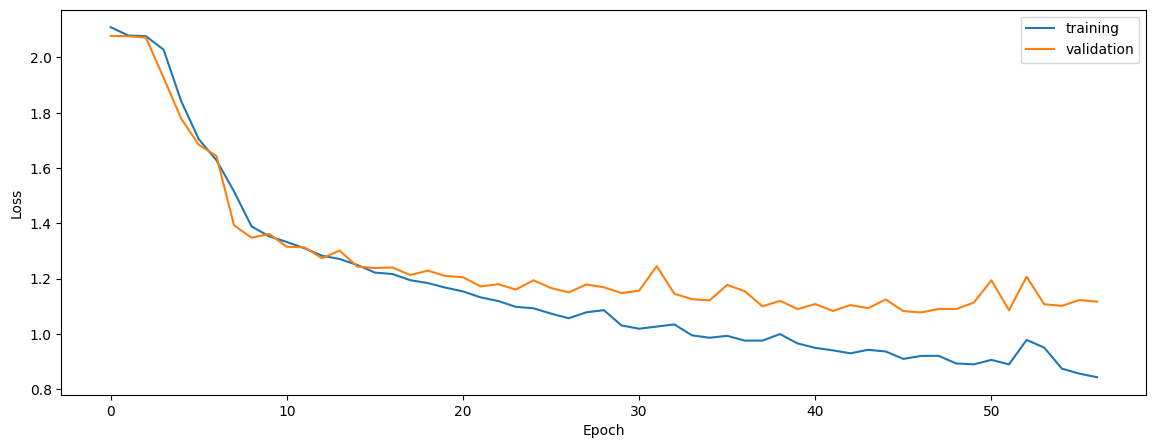

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.6604442545920547


0.5985227138806664


0.58239119424044


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.5150601983103124


0.5235639493353311


0.4485900520991519


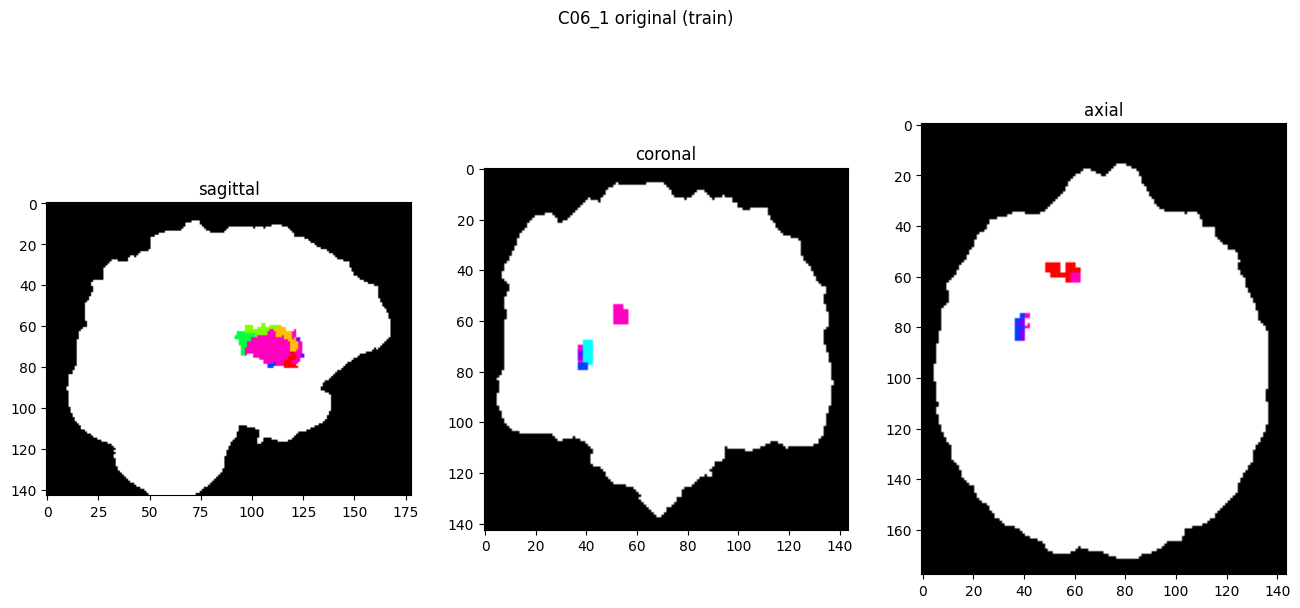

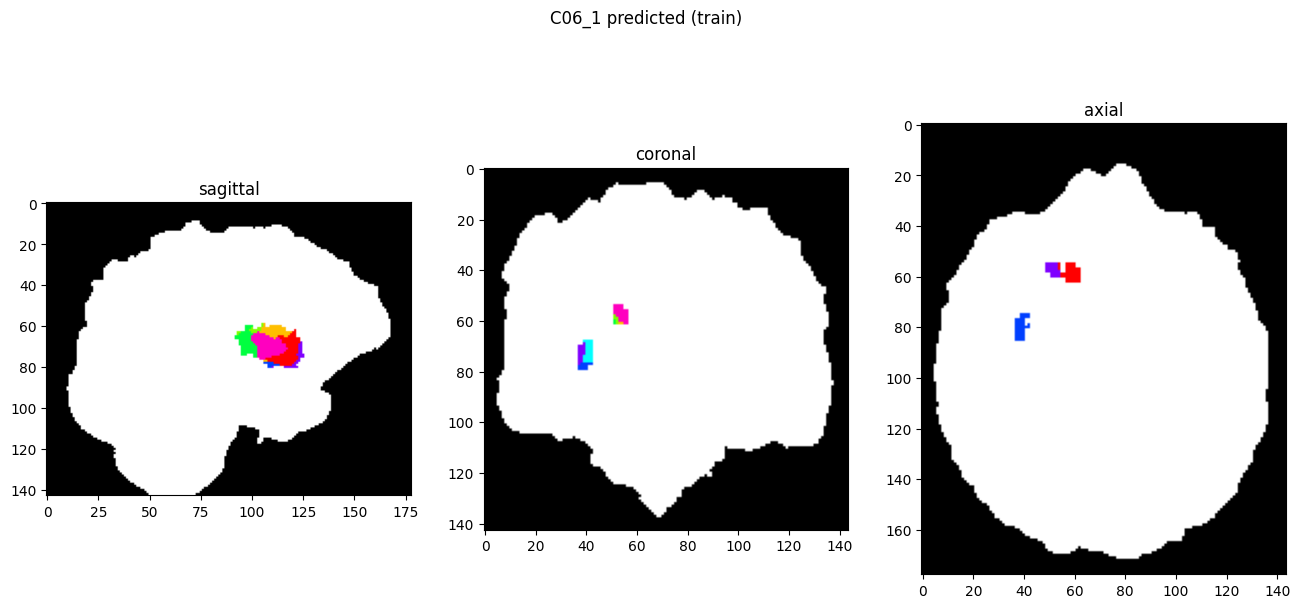

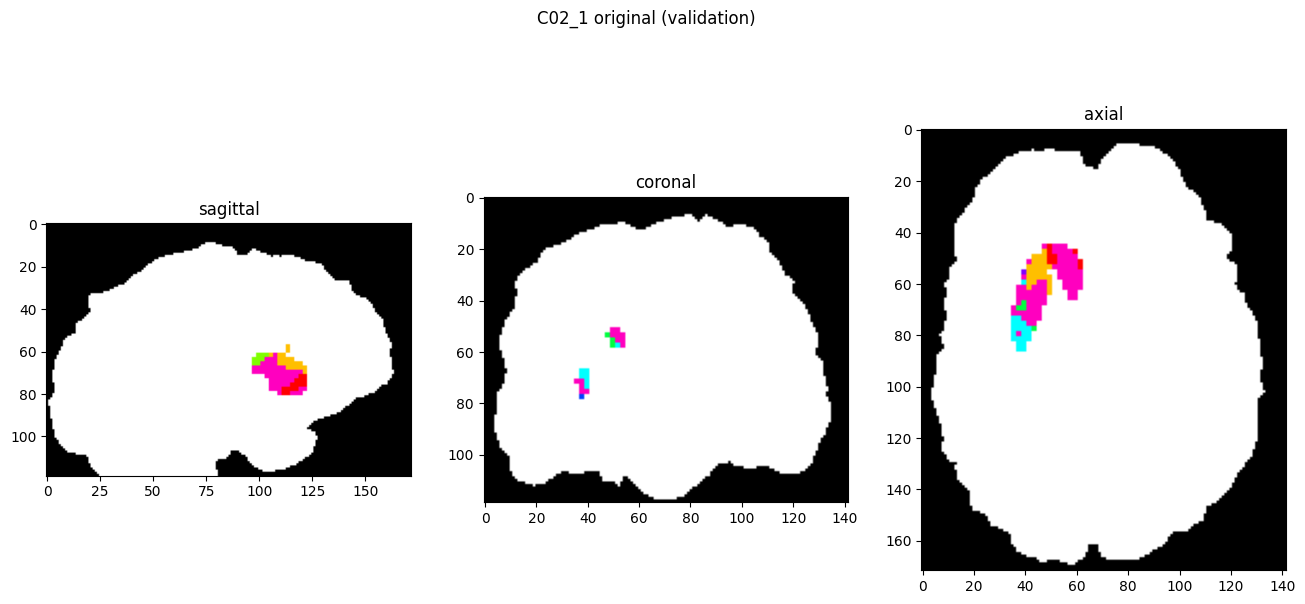

In [9]:
showResults(model, gen, threshold=0)